# Prognostic Blood Test Analysis in Pancreatic Cancer
This notebook performs a comprehensive analysis of prognostic blood tests (PBTs) in a pancreatic cancer cohort. We will:
1. Load and preprocess the data
2. Determine optimal cutpoints for each marker via log-rank tests
3. Run linear regressions vs age and sex
4. Fit univariable and age/sex-adjusted Cox proportional hazards models
5. Compute ROC AUC and F1 scores for 24-month survival
6. Generate Kaplan–Meier survival curves
7. Visualize combined forest plots and cutpoint metrics


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
from sklearn.metrics import roc_auc_score, f1_score

sns.set_style("whitegrid")
sns.set_context("talk", font_scale=1.1)


In [2]:
# Load data
df = pd.read_csv("data/Organized_Bruckner_Data.csv")

# Filter for pancreatic cancer
df = df[df['Cancer_Type'].str.contains("Pancreatic", case=False)]

# Drop missing
key_cols = ['time_diff_months','Event_Status','Age','Gender',
            'Albumin','LMR','ANC','NLR','WBC','LY','MON','HGB','HCT','PLT','Alk_Phos','Bilirubin','Prognostic_Score_ALAN']
df.dropna(subset=key_cols, inplace=True)

# Encode sex
df['Gender_bin'] = df['Gender'].map({'Male':1,'Female':0})

df.head()

ID  Gender  Age        Cancer_Type            Prior_Tx  \
204  d8a9d24503  Female   83  Pancreatic Cancer  No Prior Treatment   
205  e15cff092f    Male   60  Pancreatic Cancer     Prior Treatment   
206  f75e8549b8    Male   66  Pancreatic Cancer     Prior Treatment   
207  1d6e47f97e  Female   54  Pancreatic Cancer  No Prior Treatment   
208  48f18e6238    Male   65  Pancreatic Cancer  No Prior Treatment   

         Resistant                 Cancer_Status  time_diff_months  \
204  Non-Resistant        NPT- Pancreatic Cancer            10.226   
205      Resistant  Resistant- Pancreatic Cancer            18.552   
206      Resistant  Resistant- Pancreatic Cancer             7.161   
207  Non-Resistant        NPT- Pancreatic Cancer            29.548   
208  Non-Resistant        NPT- Pancreatic Cancer            13.567   

     Event_Status  Albumin  ...    Risk_Group_ALAN  WBC   LY  MON   HGB   HCT  \
204             1      4.5  ...  Intermediate Risk  7.6  1.2  0.6  11.3  35.8   
205             1      3.9  ...           Low Risk  6.4  1.8  0.1  11.6  37.6   
206             0      3.5  ...           Low Risk  6.3  1.7  0.6  10.8  33.0   
207             1      4.1  ...           Low Risk  5.5  1.7  0.3  11.5  35.8   
208             1      3.2  ...          High Risk  9.5  1.6  0.8  13.6  40.0   

       PLT  Alk_Phos  Bilirubin  Gender_bin  
204  282.0        63        0.4           0  
205  387.0        68        0.4           1  
206  183.0        93        0.6           1  
207  230.0        50        0.4           0  
208  158.0        83        0.5           1  

[5 rows x 24 columns]

## Determine Optimal Cutpoints
We find the cutpoint for each variable that minimizes the log-rank p-value.

In [3]:
def find_cut(df, var, time_col='time_diff_months', event_col='Event_Status', steps=50, min_pct=0.1, max_pct=0.9):
    vals = np.percentile(df[var].dropna(), np.linspace(min_pct*100, max_pct*100, steps))
    best_p, best_cut = 1.0, np.nan
    for cut in vals:
        A = df[df[var] <= cut]; B = df[df[var] > cut]
        if len(A)<10 or len(B)<10: continue
        lr = logrank_test(A[time_col], B[time_col],
                         event_observed_A=A[event_col], event_observed_B=B[event_col])
        if lr.p_value < best_p:
            best_p, best_cut = lr.p_value, cut
    return best_cut, best_p

vars_to_cut = ['Albumin','LMR','ANC','NLR','WBC','LY','MON','HGB','HCT','PLT','Alk_Phos','Bilirubin','Prognostic_Score_ALAN']
cutpoints = {}
cut_pvals = {}
for var in vars_to_cut:
    cut, p = find_cut(df, var)
    cutpoints[var] = cut
    cut_pvals[var] = p
    df[f"{var}_flag"] = (df[var] > cut).astype(int)

pd.DataFrame({'cutpoint':cutpoints, 'p_value':cut_pvals})

cutpoint       p_value
Albumin                  3.600000  5.456440e-09
LMR                      1.827143  4.464246e-03
ANC                      8.392857  4.161011e-06
NLR                      9.532143  9.858961e-10
WBC                     11.664286  2.544689e-04
LY                       2.200000  1.857381e-01
MON                      0.700000  1.595873e-03
HGB                      9.150000  2.411180e-03
HCT                     30.614286  7.641659e-05
PLT                    388.500000  1.517998e-02
Alk_Phos               107.357143  1.857394e-03
Bilirubin                0.700000  5.949554e-02
Prognostic_Score_ALAN    2.000000  9.481910e-11

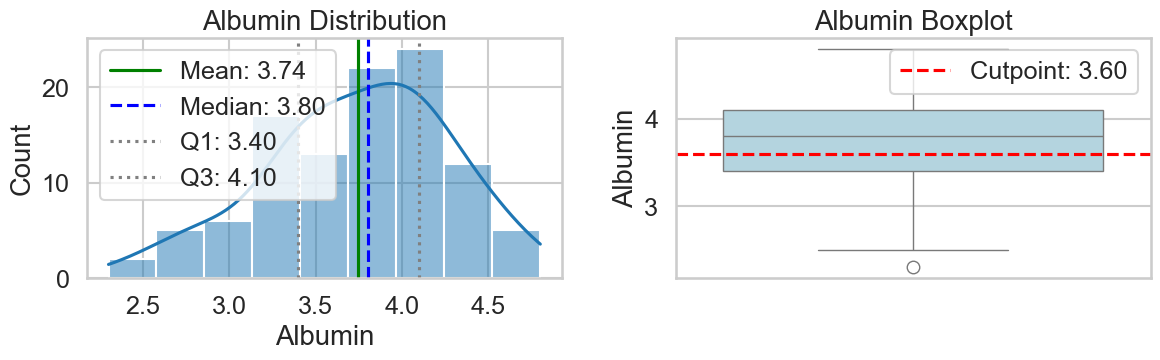

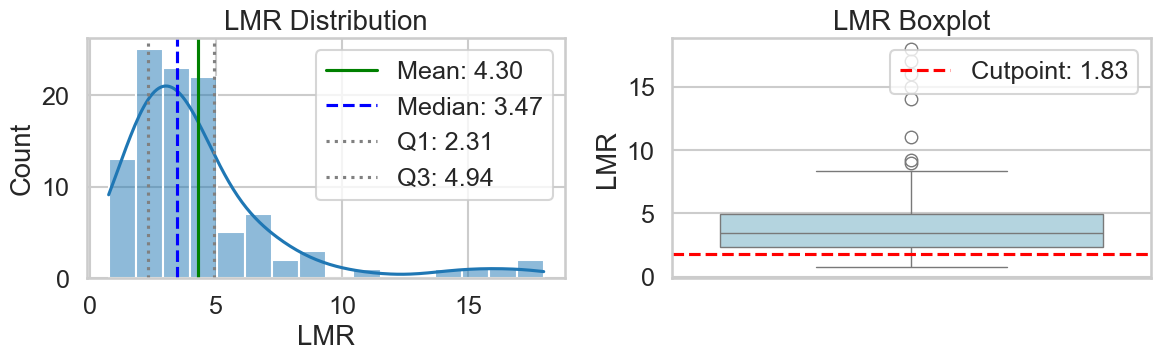

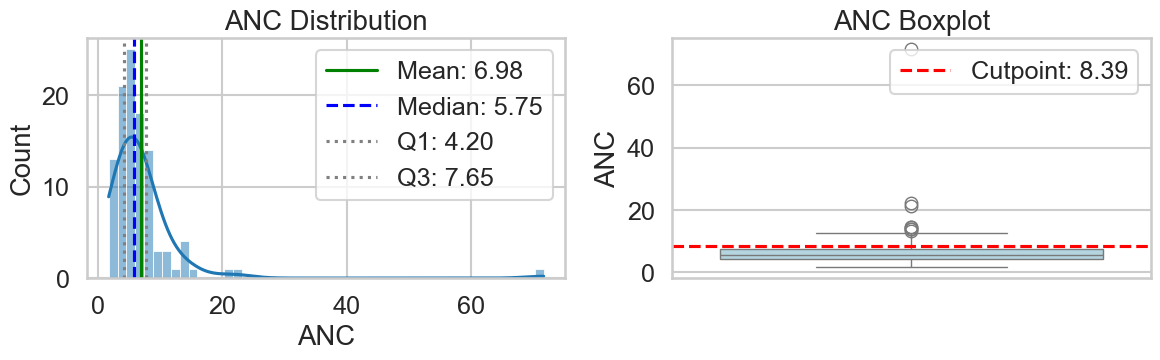

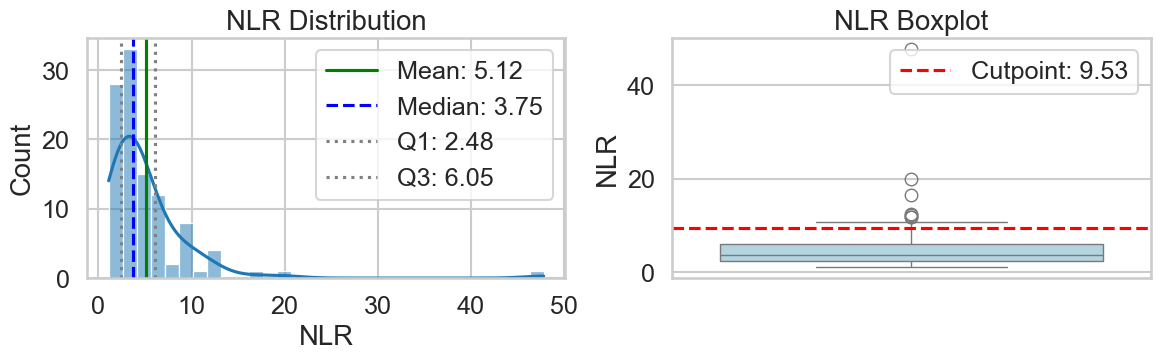

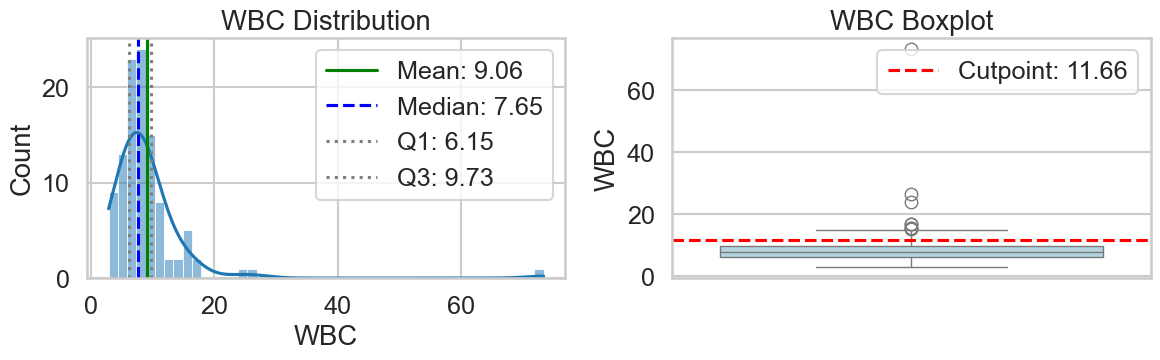

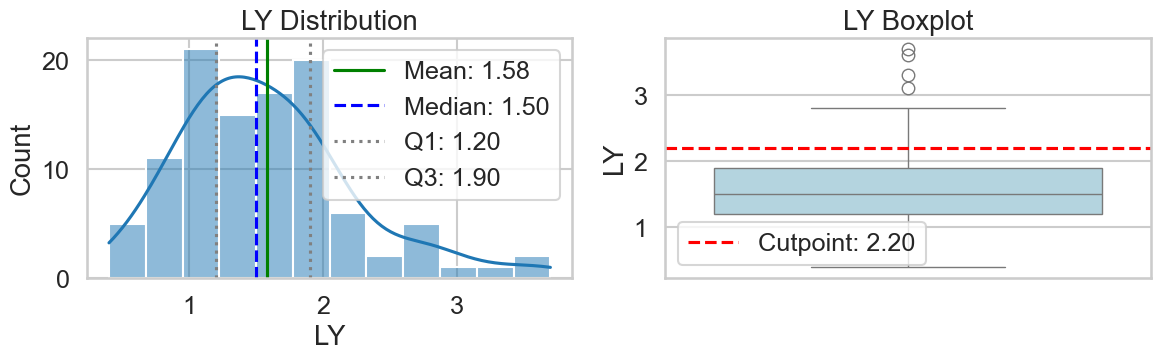

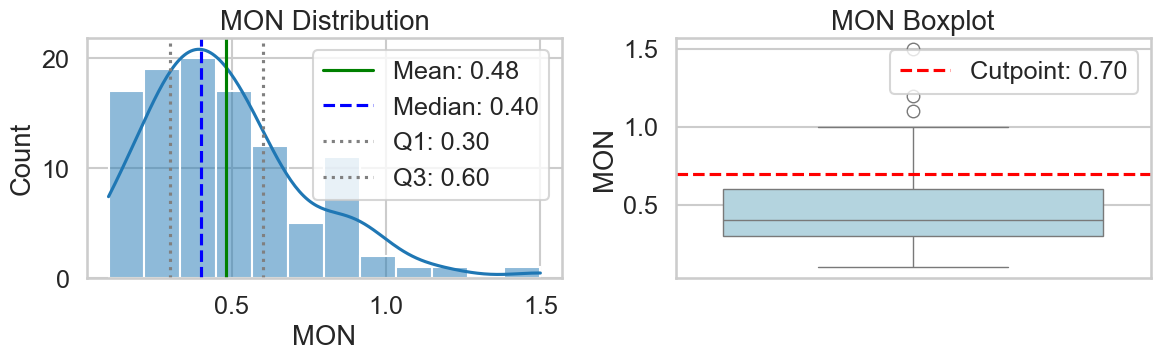

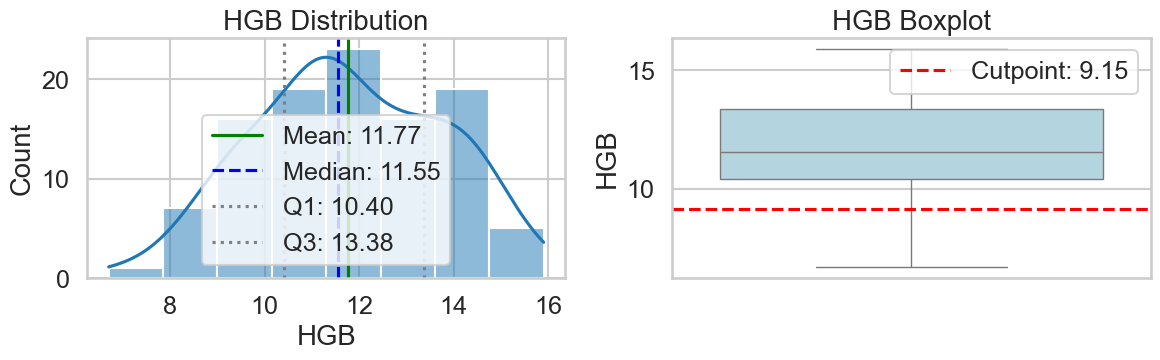

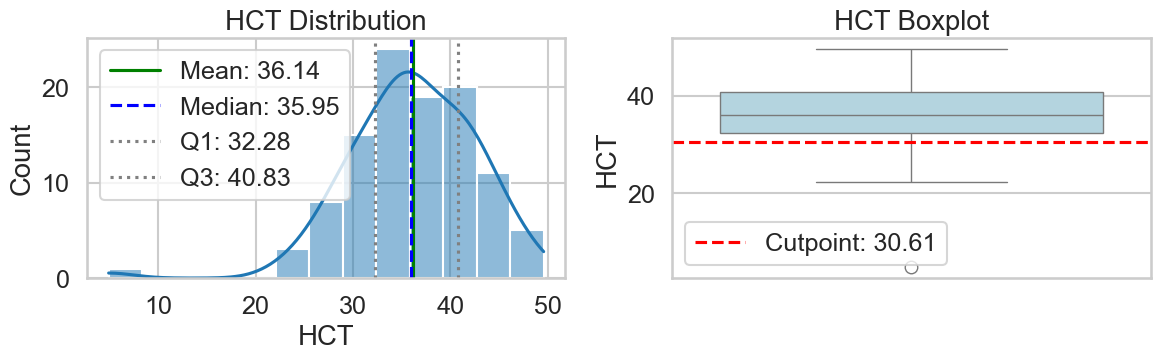

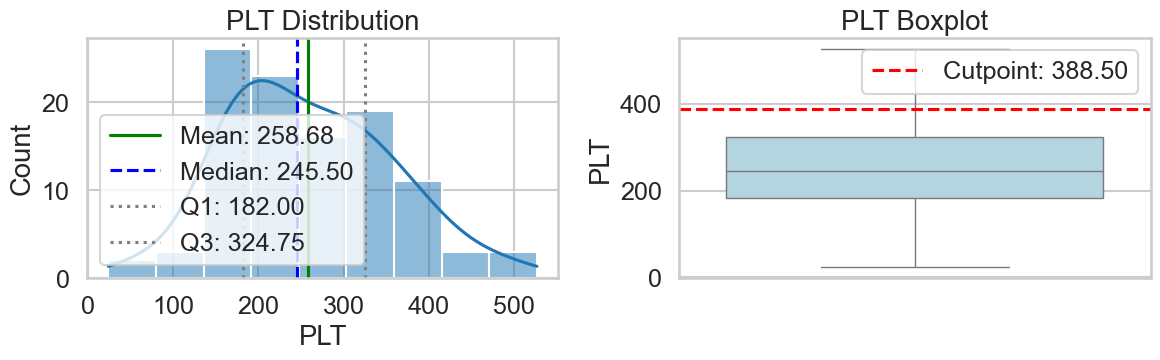

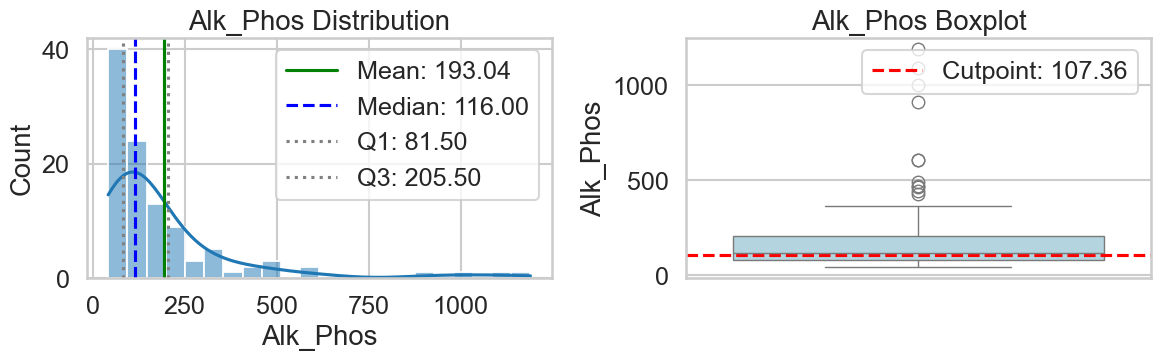

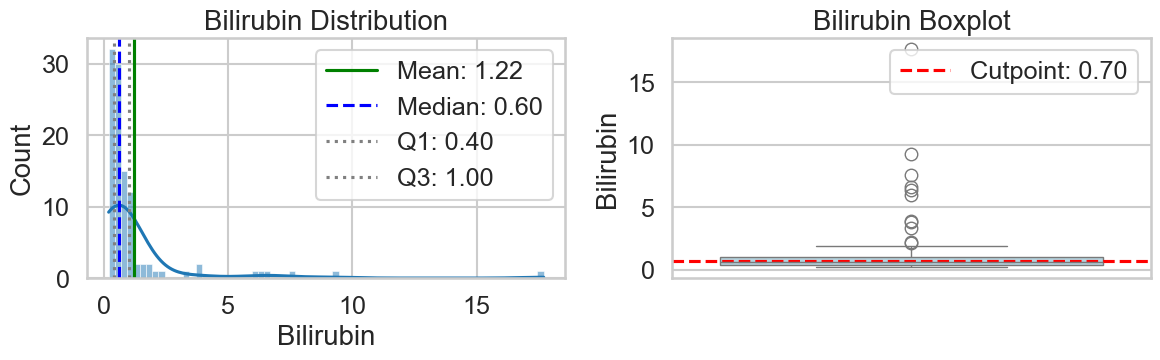

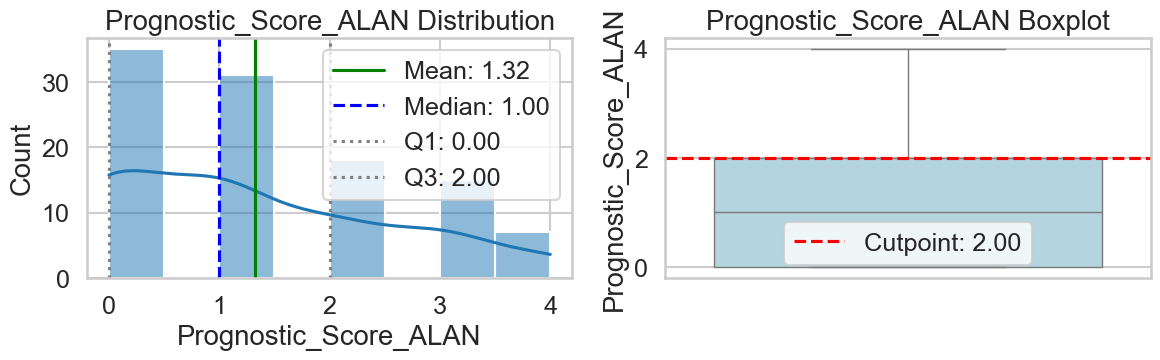

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


def plot_distribution_with_cutpoints(df, var, cut: float):
    """
    Plot histogram of `var` with mean, median, Q1, Q3 lines and a boxplot with cutpoint.
    """
    # Compute summary stats
    mean = df[var].mean()
    median = df[var].median()
    q1, q3 = df[var].quantile([0.25, 0.75])

    # Histogram + KDE
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    sns.histplot(df[var], kde=True, ax=axes[0])
    # Vertical lines
    axes[0].axvline(mean,  color='green', linestyle='-',
                    label=f"Mean: {mean:.2f}")
    axes[0].axvline(median, color='blue',  linestyle='--',
                    label=f"Median: {median:.2f}")
    axes[0].axvline(q1,     color='gray',  linestyle=':',
                    label=f"Q1: {q1:.2f}")
    axes[0].axvline(q3,     color='gray',  linestyle=':',
                    label=f"Q3: {q3:.2f}")
    axes[0].set_title(f"{var} Distribution")
    axes[0].legend()

    # Boxplot with cutpoint
    sns.boxplot(y=df[var], ax=axes[1], color="lightblue")
    axes[1].axhline(cut, color='red', linestyle='--',
                    label=f"Cutpoint: {cut:.2f}")
    axes[1].set_title(f"{var} Boxplot")
    axes[1].legend()

    plt.tight_layout()
    plt.show()


# Example usage for all variables:
for var, cut in cutpoints.items():
    plot_distribution_with_cutpoints(df, var, cut)

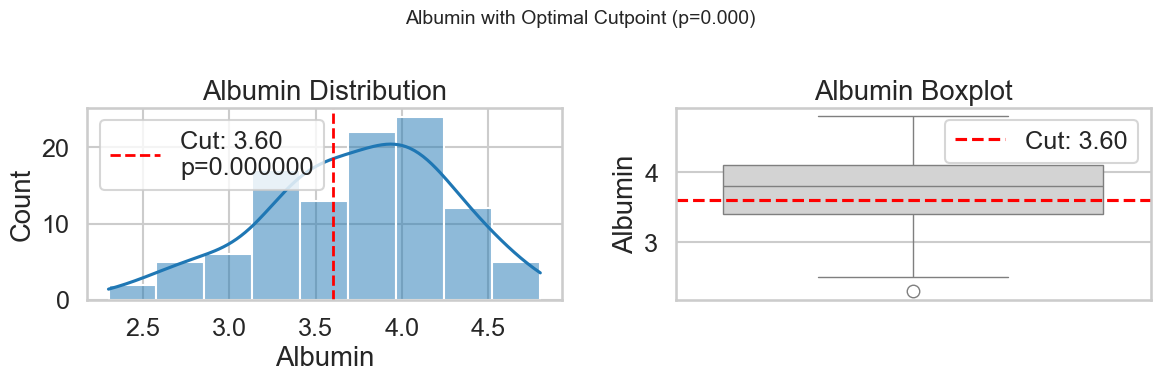

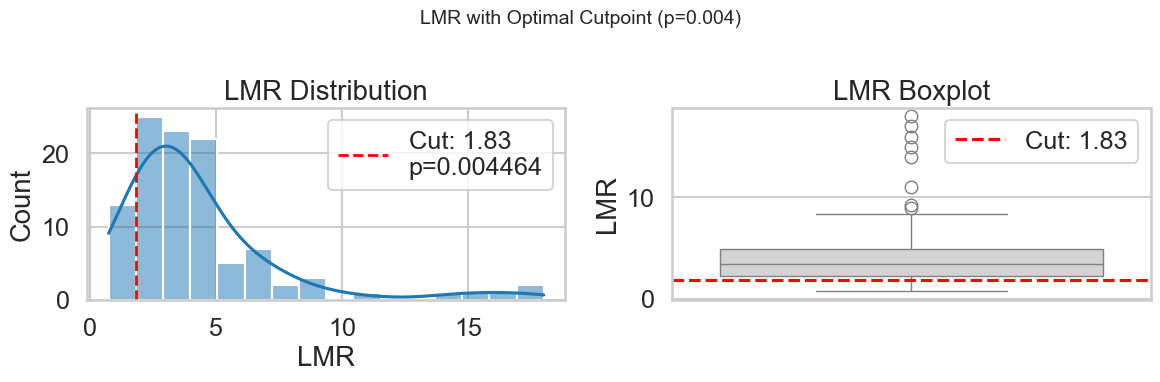

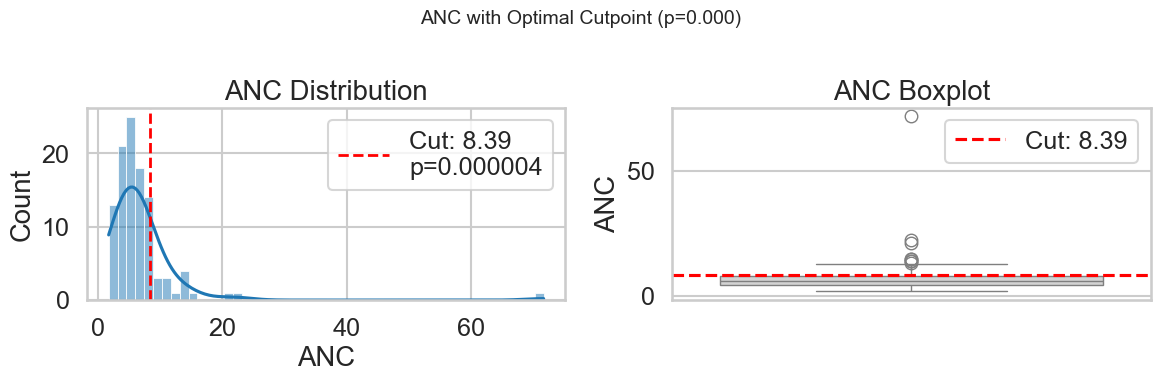

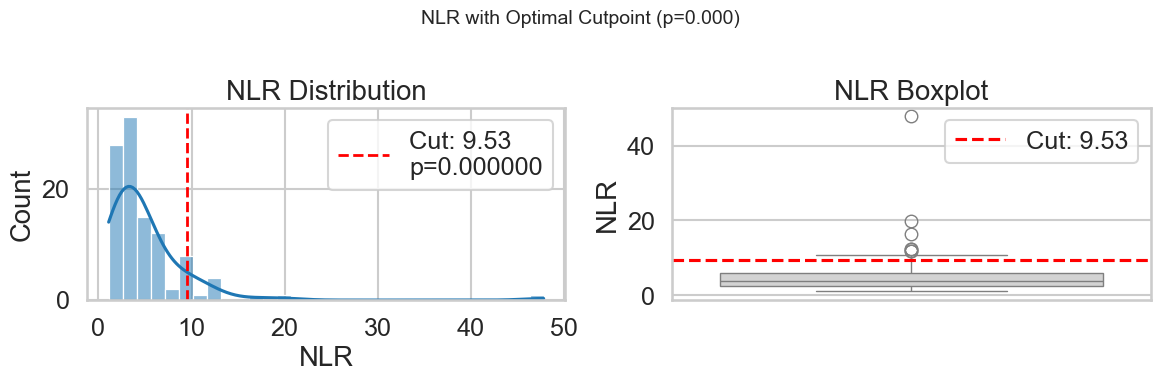

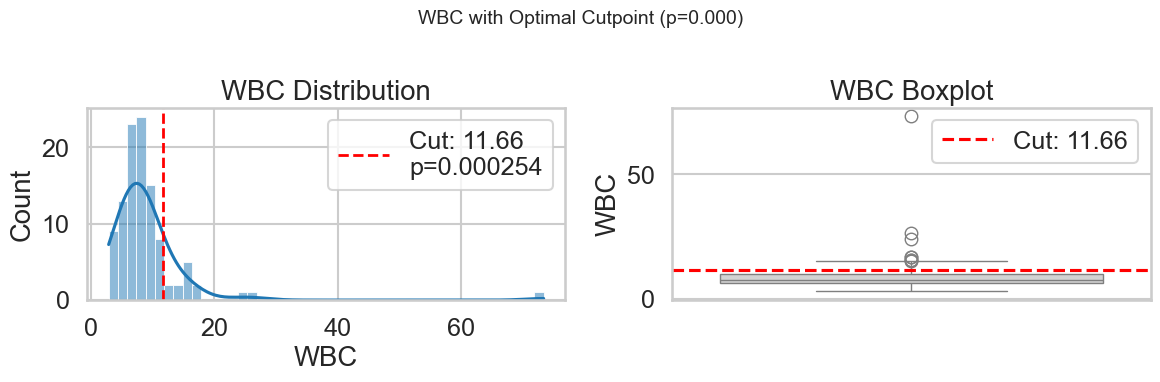

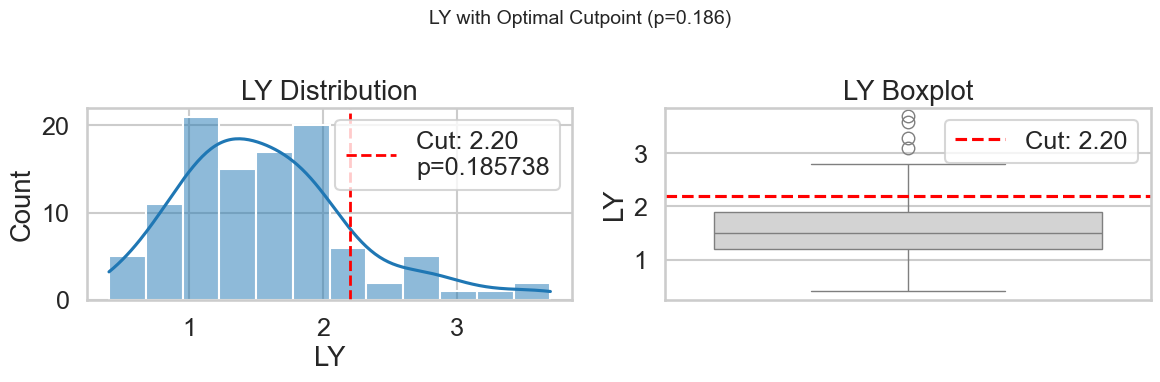

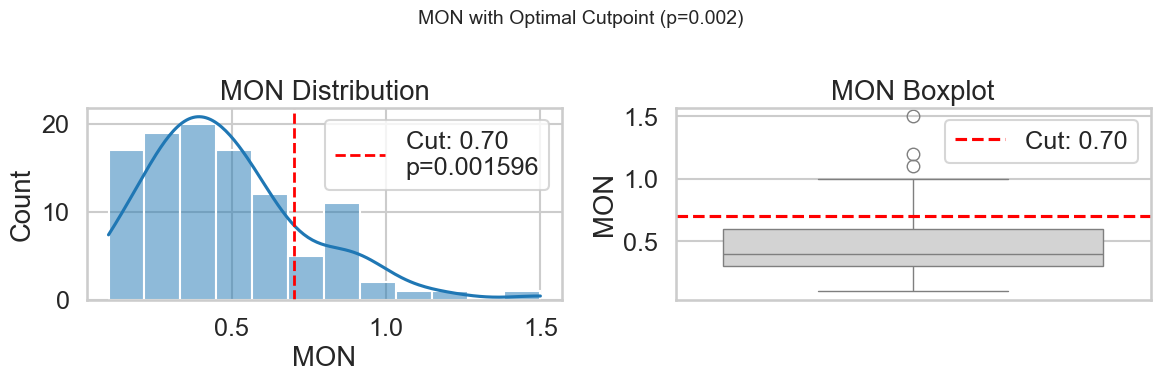

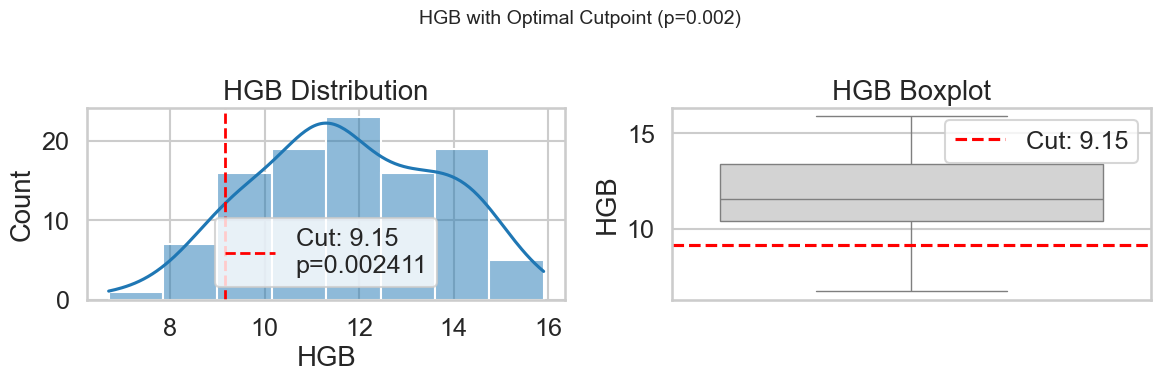

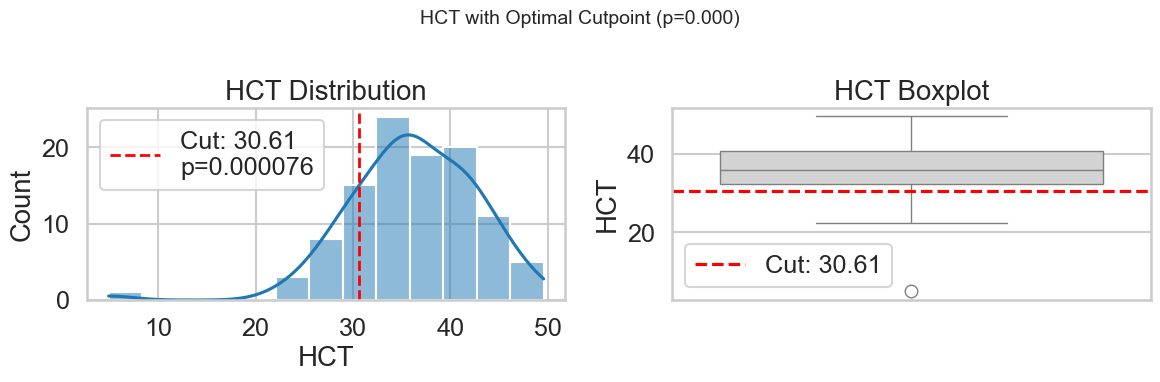

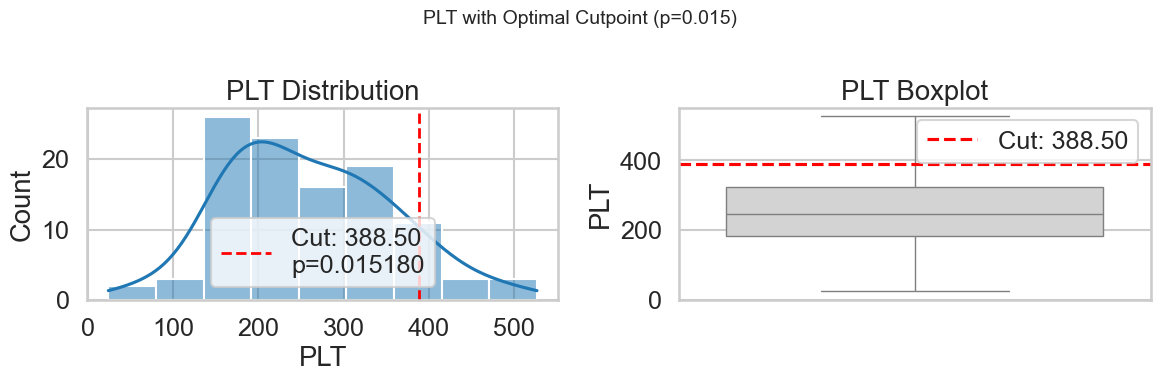

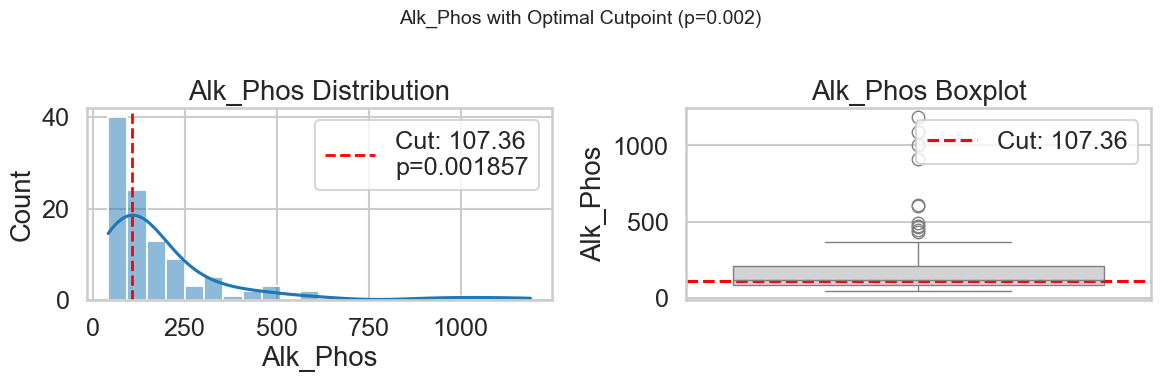

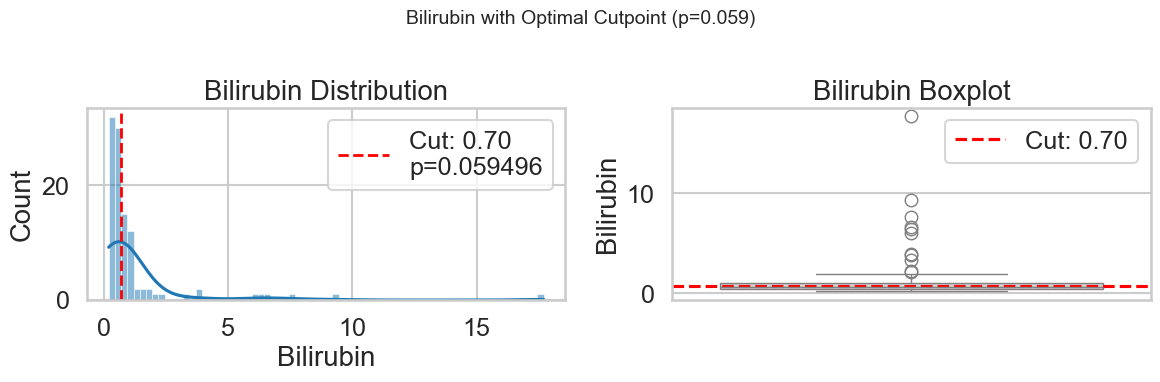

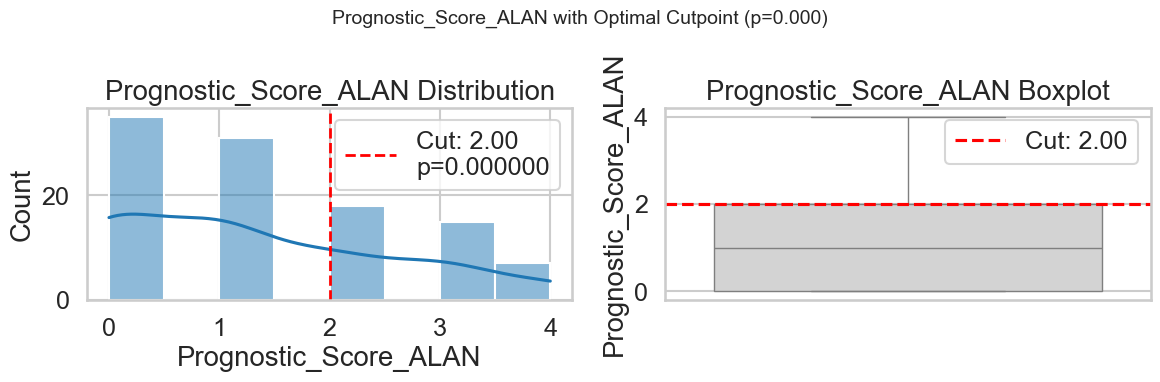

In [5]:
# 1. Histograms & Boxplots with Cutpoints and p‑values

import matplotlib.pyplot as plt
import seaborn as sns
from lifelines.statistics import logrank_test

sns.set_style("whitegrid")
sns.set_context("talk", font_scale=1.1)

for var, cut in cutpoints.items():
    pval = cut_pvals[var]
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Histogram + KDE
    sns.histplot(df[var], kde=True, ax=axes[0])
    axes[0].axvline(cut, color='red', linestyle='--', linewidth=2,
                    label=f'Cut: {cut:.2f}\np={pval:.6f}')
    axes[0].set_title(f'{var} Distribution')
    axes[0].legend()

    # Boxplot
    sns.boxplot(y=df[var], ax=axes[1], color='lightgray')
    axes[1].axhline(cut, color='red', linestyle='--',
                    label=f'Cut: {cut:.2f}')
    axes[1].set_title(f'{var} Boxplot')
    axes[1].legend()

    plt.suptitle(f'{var} with Optimal Cutpoint (p={pval:.3f})', fontsize=14)
    plt.tight_layout()
    plt.show()

## Linear Regression vs Age and Sex
We regress each variable on age and sex.

In [6]:
lin_stats = {}
for var in vars_to_cut:
    res = smf.ols(f"{var} ~ Age + Gender_bin", data=df).fit()
    lin_stats[var] = {'coef_age':res.params['Age'],'p_age':res.pvalues['Age'],
                      'coef_sex':res.params['Gender_bin'],'p_sex':res.pvalues['Gender_bin']}
pd.DataFrame(lin_stats).T

coef_age     p_age   coef_sex     p_sex
Albumin               -0.006589  0.199551  -0.194183  0.061699
LMR                   -0.032486  0.307033  -0.107280  0.866675
ANC                   -0.102293  0.143321   2.158304  0.125460
NLR                   -0.052843  0.305349   1.573718  0.130801
WBC                   -0.099217  0.162184   2.271753  0.112583
LY                     0.001646  0.796547   0.015597  0.903432
MON                    0.001709  0.487367   0.131027  0.009252
HGB                   -0.007304  0.700935   0.784071  0.042661
HCT                   -0.043453  0.491868   2.451306  0.056117
PLT                    1.079208  0.258995   6.577351  0.731976
Alk_Phos              -0.699773  0.730508 -37.829312  0.356118
Bilirubin              0.007374  0.732320   0.619153  0.155860
Prognostic_Score_ALAN  0.014462  0.226406   0.547977  0.024109

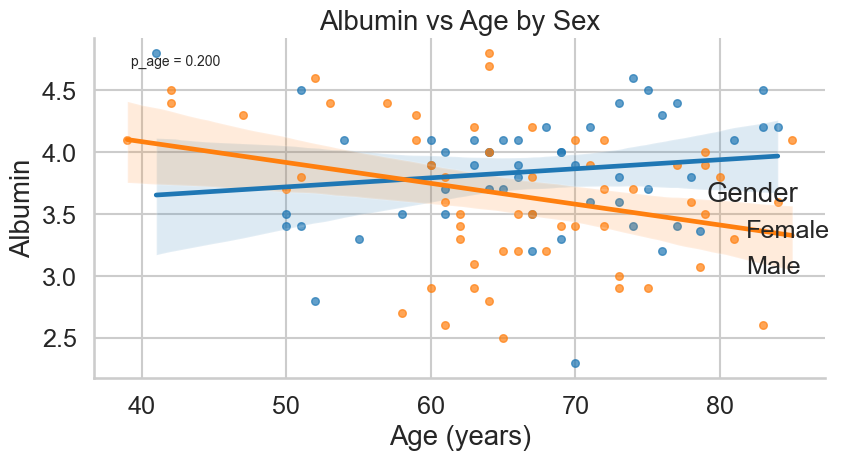

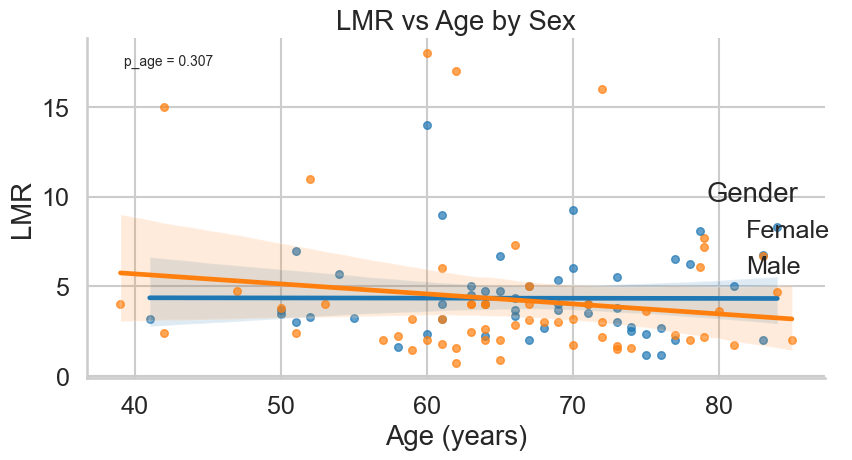

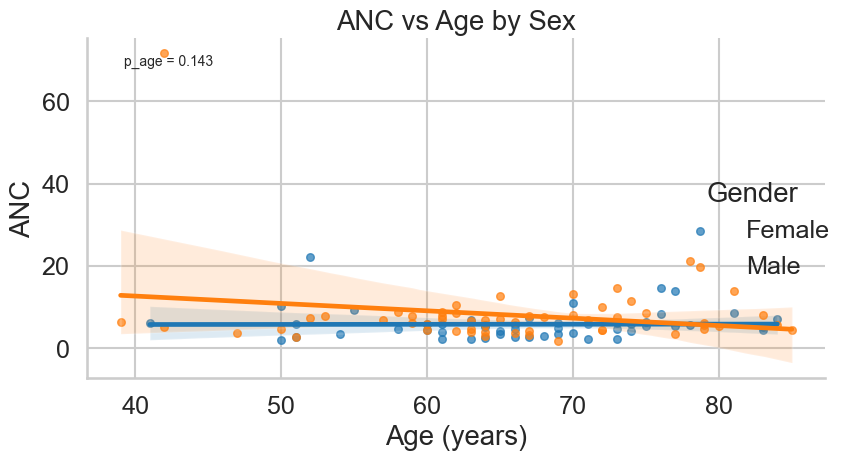

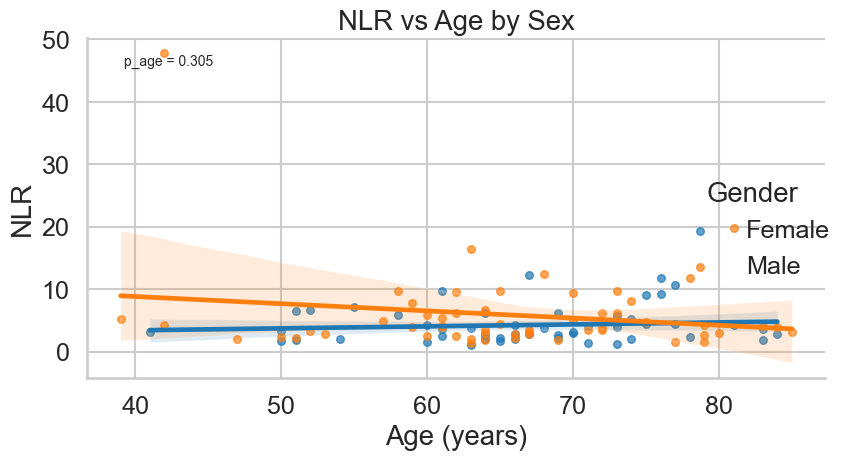

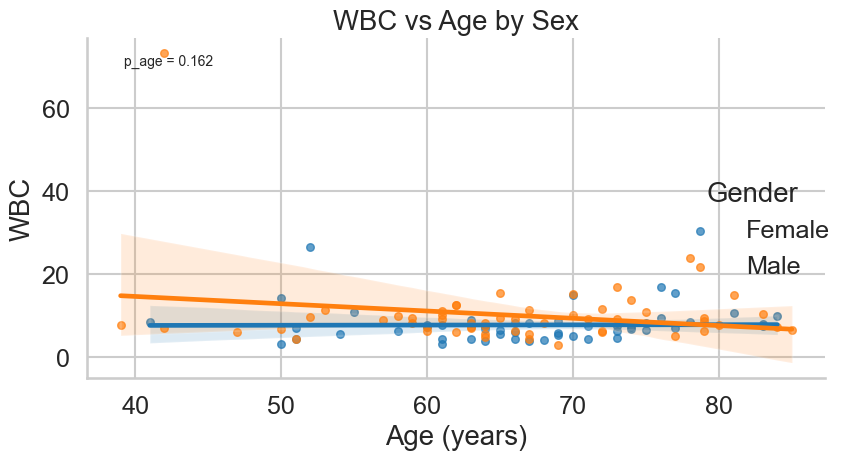

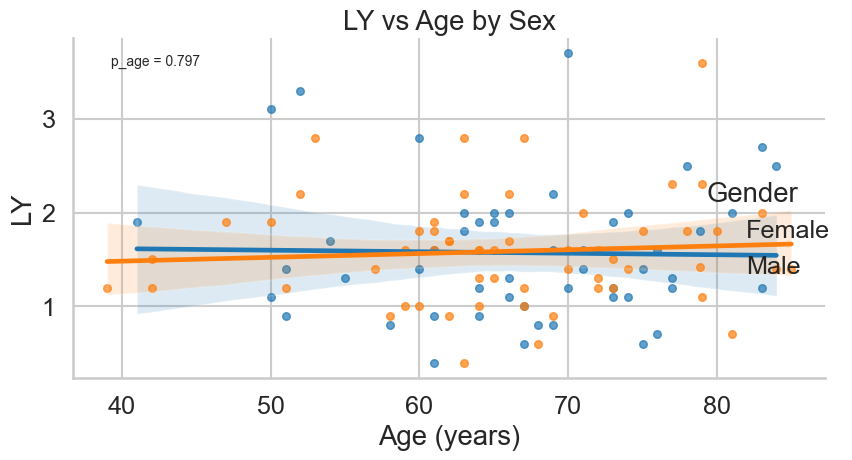

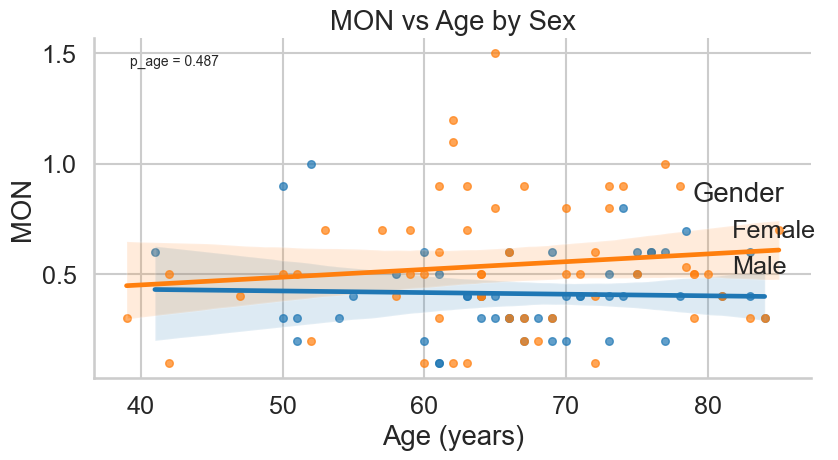

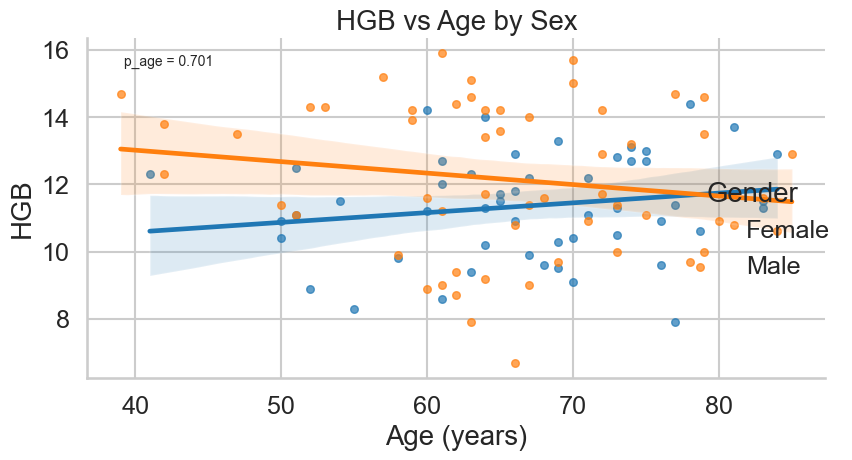

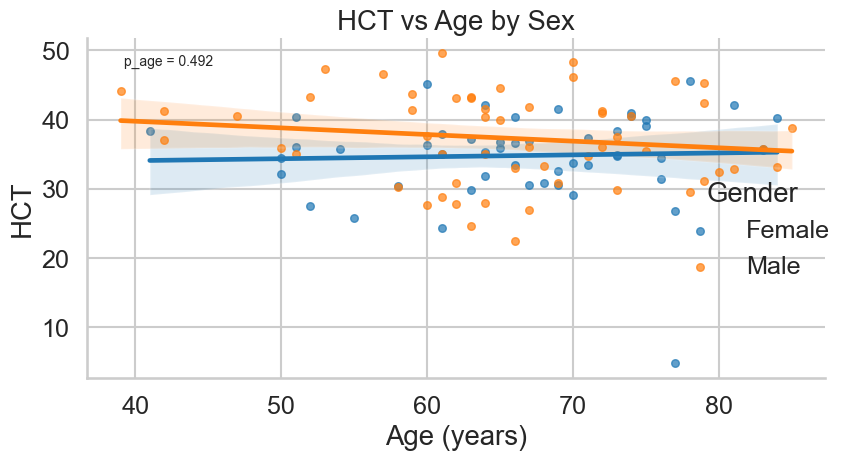

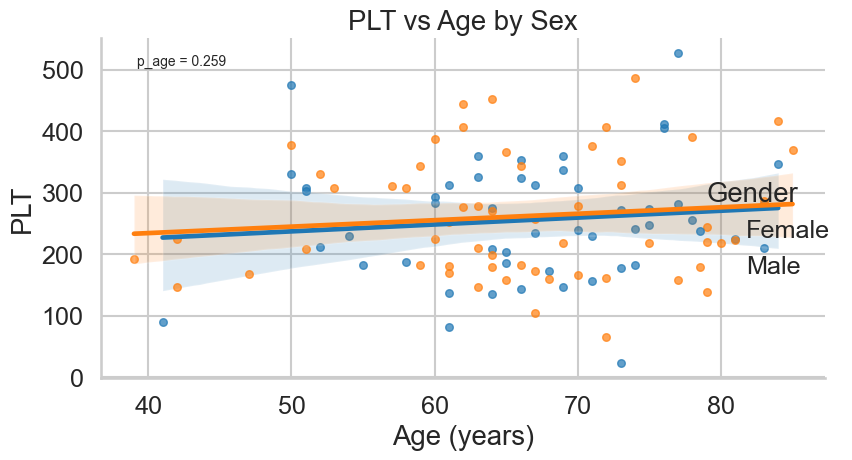

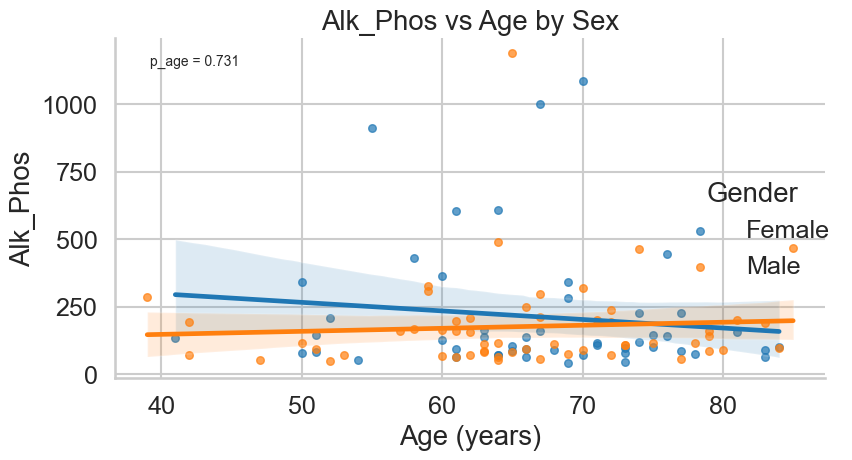

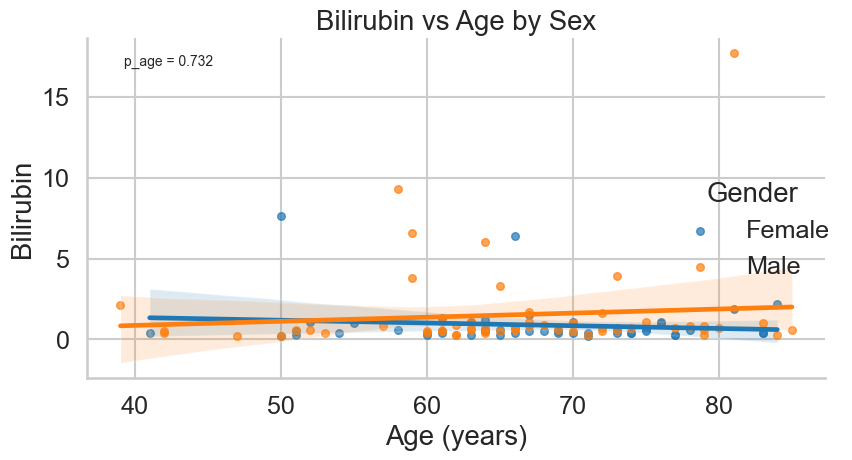

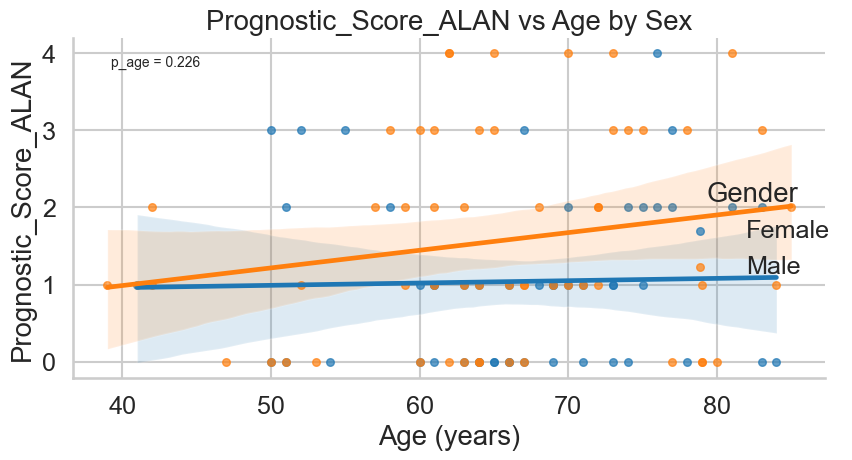

In [7]:
# 2. Scatter + Regression with p‑value annotation

import seaborn as sns
import matplotlib.pyplot as plt

for var in vars_to_cut:
    p_age = lin_stats[var]['p_age']

    g = sns.lmplot(
        x='Age', y=var, hue='Gender', data=df,
        height=5, aspect=1.4,
        scatter_kws={'s': 30, 'alpha': 0.7}
    )
    ax = g.ax
    ax.text(0.05, 0.95, f"p_age = {p_age:.3f}",
            transform=ax.transAxes,
            fontsize=10, verticalalignment='top')
    ax.set_title(f'{var} vs Age by Sex')
    g.set_axis_labels("Age (years)", var)
    plt.tight_layout()
    plt.show()

## Cox Proportional Hazards Models
Univariable and age/sex-adjusted models for each marker.

In [8]:
cph_uni = CoxPHFitter(); cph_adj = CoxPHFitter()
cox_stats = {}
for var in vars_to_cut:
    cph_uni.fit(df[['time_diff_months','Event_Status',var]], 'time_diff_months','Event_Status')
    hr_u = cph_uni.hazard_ratios_[var]; p_u = cph_uni.summary.loc[var,'p']
    sub = df[['time_diff_months','Event_Status','Age','Gender_bin',var]].dropna()
    cph_adj.fit(sub, 'time_diff_months','Event_Status')
    hr_a = cph_adj.hazard_ratios_[var]; p_a = cph_adj.summary.loc[var,'p']
    cox_stats[var] = {'HR_univ':hr_u,'p_univ':p_u,'HR_adj':hr_a,'p_adj':p_a}
pd.DataFrame(cox_stats).T

HR_univ        p_univ    HR_adj         p_adj
Albumin                0.298094  3.476686e-07  0.312129  4.871332e-07
LMR                    0.951488  2.559799e-01  0.952519  2.412099e-01
ANC                    1.016161  1.412693e-01  1.010178  3.872358e-01
NLR                    1.032955  2.152937e-02  1.025545  9.632519e-02
WBC                    1.015808  1.521773e-01  1.009731  4.103478e-01
LY                     0.836702  3.470470e-01  0.802356  2.628354e-01
MON                    3.304661  2.148958e-02  2.673387  6.439248e-02
HGB                    0.911593  1.730019e-01  0.862857  3.277065e-02
HCT                    0.962595  5.740026e-02  0.945311  6.454414e-03
PLT                    1.001859  1.793007e-01  1.001880  1.717275e-01
Alk_Phos               1.002458  3.435934e-04  1.002551  3.008741e-04
Bilirubin              1.188260  4.109788e-03  1.171463  1.004558e-02
Prognostic_Score_ALAN  1.751571  8.438684e-07  1.720775  1.991579e-06

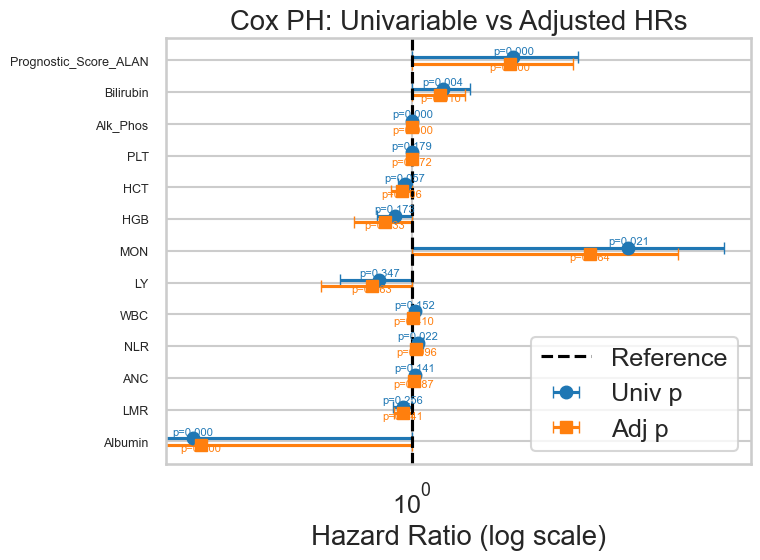

In [9]:
# 3. Cox PH Forest Plot with p‑values

import numpy as np
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter

# Ensure CoxPH models have been fit to produce cox_stats
fig, ax = plt.subplots(figsize=(8, 6))
y = np.arange(len(cox_stats))

for idx, var in enumerate(cox_stats):
    hr_u = cox_stats[var]['HR_univ']
    pu = cox_stats[var]['p_univ']
    hr_a = cox_stats[var]['HR_adj']
    pa = cox_stats[var]['p_adj']

    # Univariable point + p‑value
    ax.errorbar(hr_u, idx+0.1,
                xerr=[[abs(hr_u-1)], [abs(hr_u-1)]],
                fmt='o', color='C0', capsize=4)
    ax.text(hr_u, idx+0.2, f"p={pu:.3f}",
            color='C0', fontsize=8, ha='center')

    # Adjusted point + p‑value
    ax.errorbar(hr_a, idx-0.1,
                xerr=[[abs(hr_a-1)], [abs(hr_a-1)]],
                fmt='s', color='C1', capsize=4)
    ax.text(hr_a, idx-0.3, f"p={pa:.3f}",
            color='C1', fontsize=8, ha='center')

ax.axvline(1, color='black', linestyle='--')
ax.set_yticks(y)
ax.set_yticklabels(list(cox_stats.keys()), fontsize=9)
ax.set_xscale('log')
ax.set_xlabel('Hazard Ratio (log scale)')
ax.set_title('Cox PH: Univariable vs Adjusted HRs')
ax.legend(['Reference', 'Univ p', 'Adj p'], loc='lower right')
plt.tight_layout()
plt.show()

## ROC AUC and F1 for 24-month Survival
We define long-term survival as event-free at 24 months.

In [10]:
# Create 24-month survival label
df['surv_24'] = ((df['time_diff_months'] >= 24) & (df['Event_Status']==0)).astype(int)

auc_stats, f1_stats = {}, {}
for var in vars_to_cut:
    y_true = df['surv_24']; y_pred = df[f"{var}_flag"]
    auc_stats[var] = roc_auc_score(y_true, y_pred)
    f1_stats[var] = f1_score(y_true, y_pred)
pd.DataFrame({'AUC_24mo':auc_stats, 'F1_24mo':f1_stats})

AUC_24mo   F1_24mo
Albumin                0.721649  0.250000
LMR                    0.506300  0.156863
ANC                    0.396907  0.000000
NLR                    0.432990  0.000000
WBC                    0.427835  0.000000
LY                     0.554410  0.181818
MON                    0.417526  0.000000
HGB                    0.556701  0.173077
HCT                    0.603093  0.189474
PLT                    0.443299  0.000000
Alk_Phos               0.246277  0.028571
Bilirubin              0.380298  0.045455
Prognostic_Score_ALAN  0.386598  0.000000

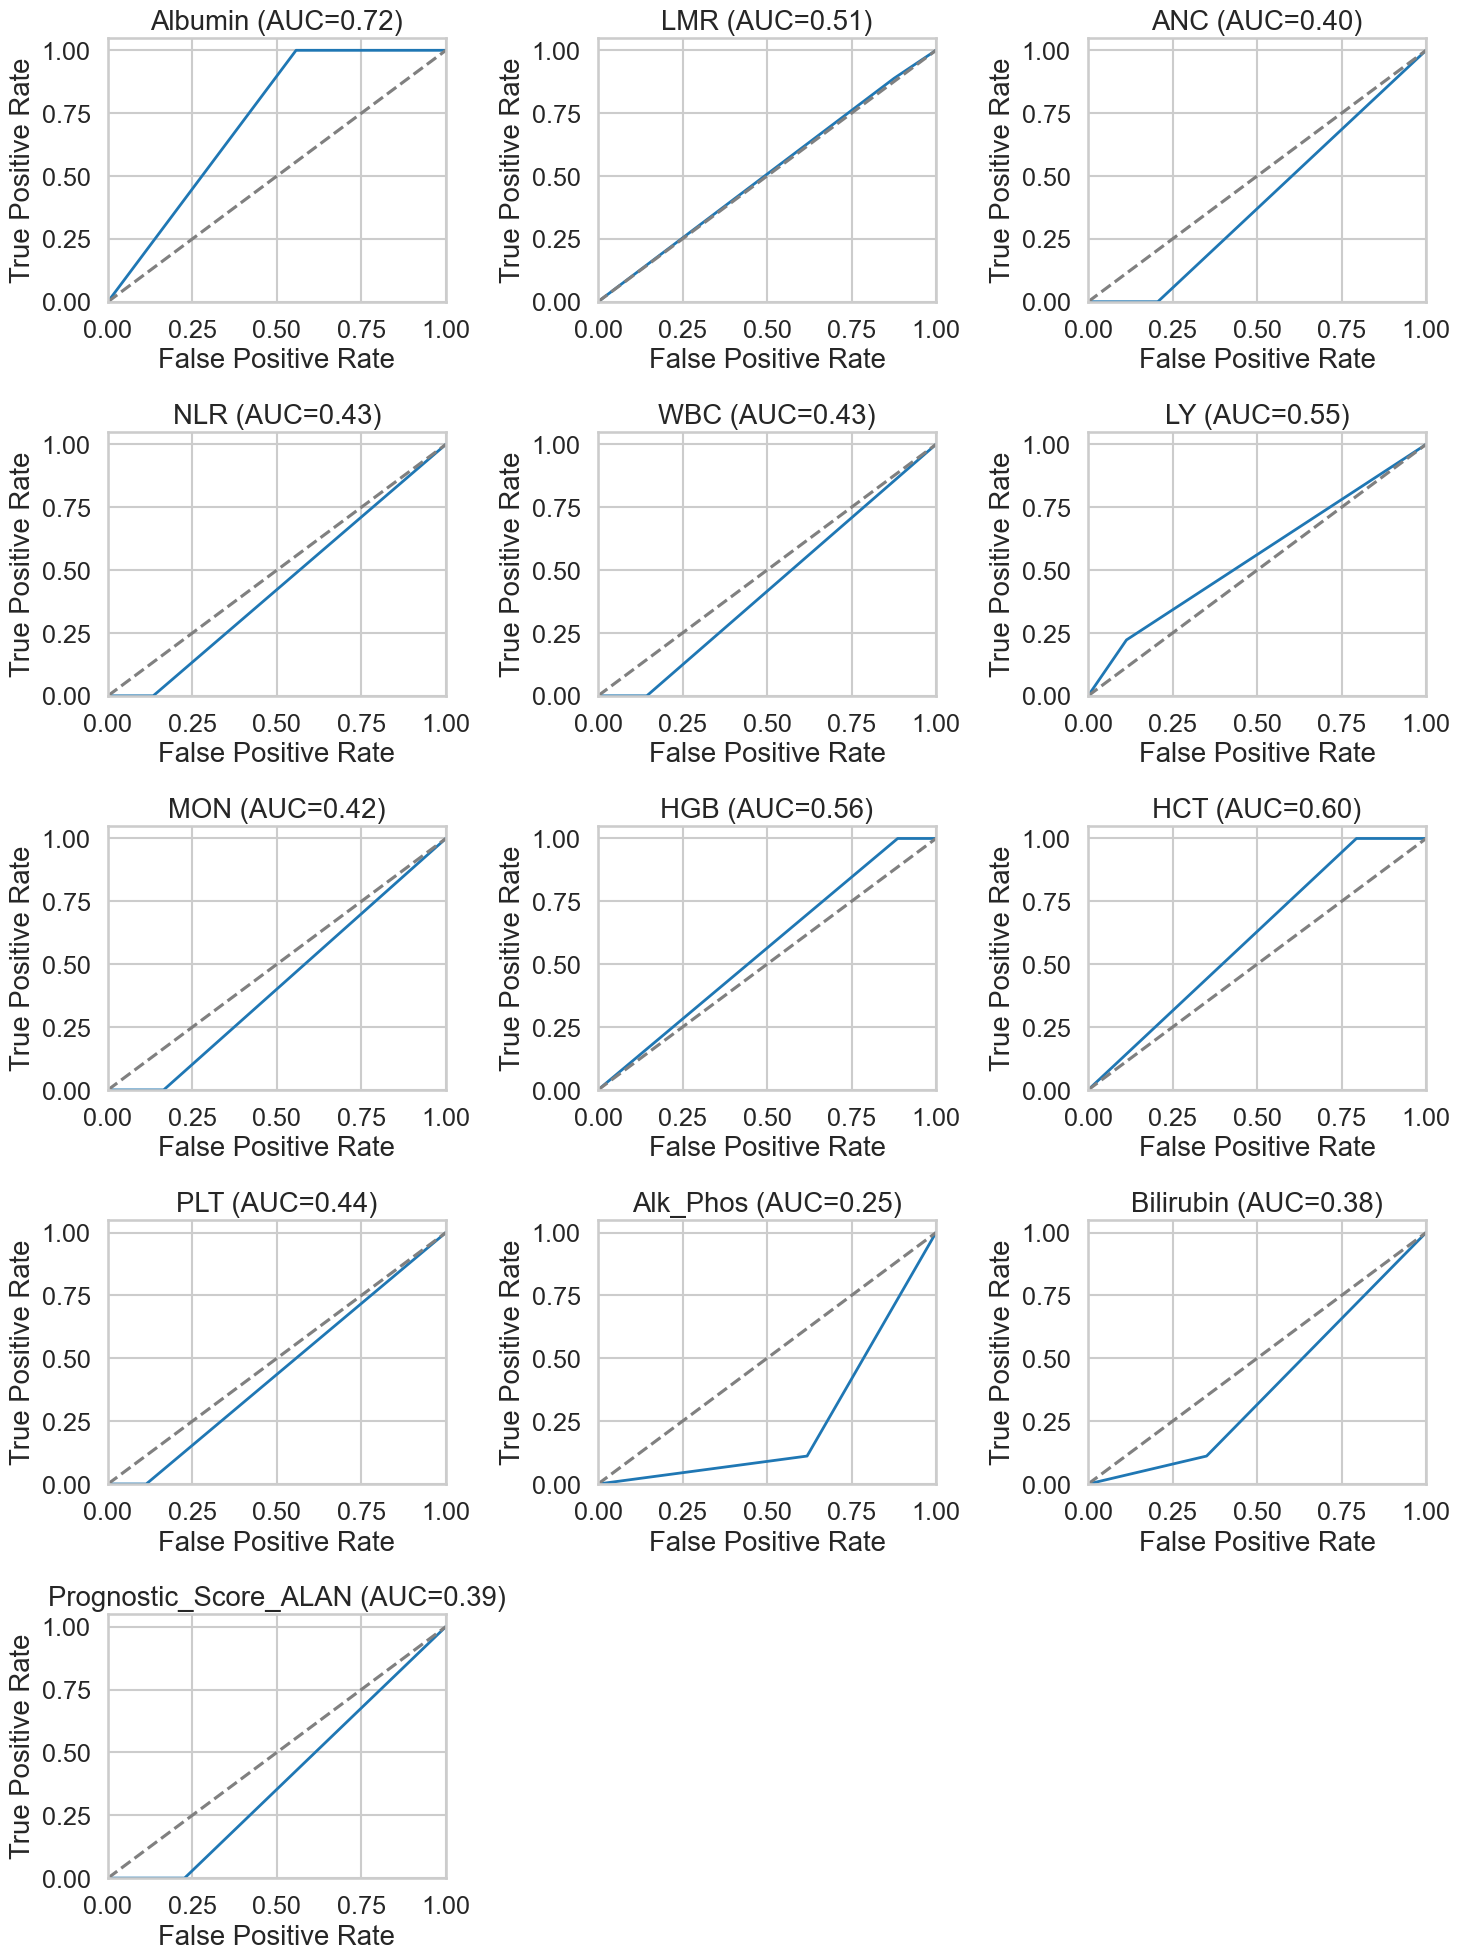

In [11]:
# 1. ROC Curves in a Grid of Subplots

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc

# Prepare variables
vars_to_plot = vars_to_cut  # ['Albumin', 'LMR', ..., 'Prognostic_Score_ALAN']
n = len(vars_to_plot)
cols = 3
rows = int(np.ceil(n / cols))

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
axes = axes.flatten()

for i, var in enumerate(vars_to_plot):
    ax = axes[i]
    y_true = df['surv_24']
    y_score = df[f"{var}_flag"]
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, lw=2)
    ax.plot([0, 1], [0, 1], color='gray', linestyle='--')
    ax.set_title(f"{var} (AUC={roc_auc:.2f})")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1.05)

# Turn off any unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

## Kaplan–Meier Survival Curves
We show KM curves for combined ALAN score and each individual marker.

C:\Users\ajboo\AppData\Local\Temp\ipykernel_38476\2034805138.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


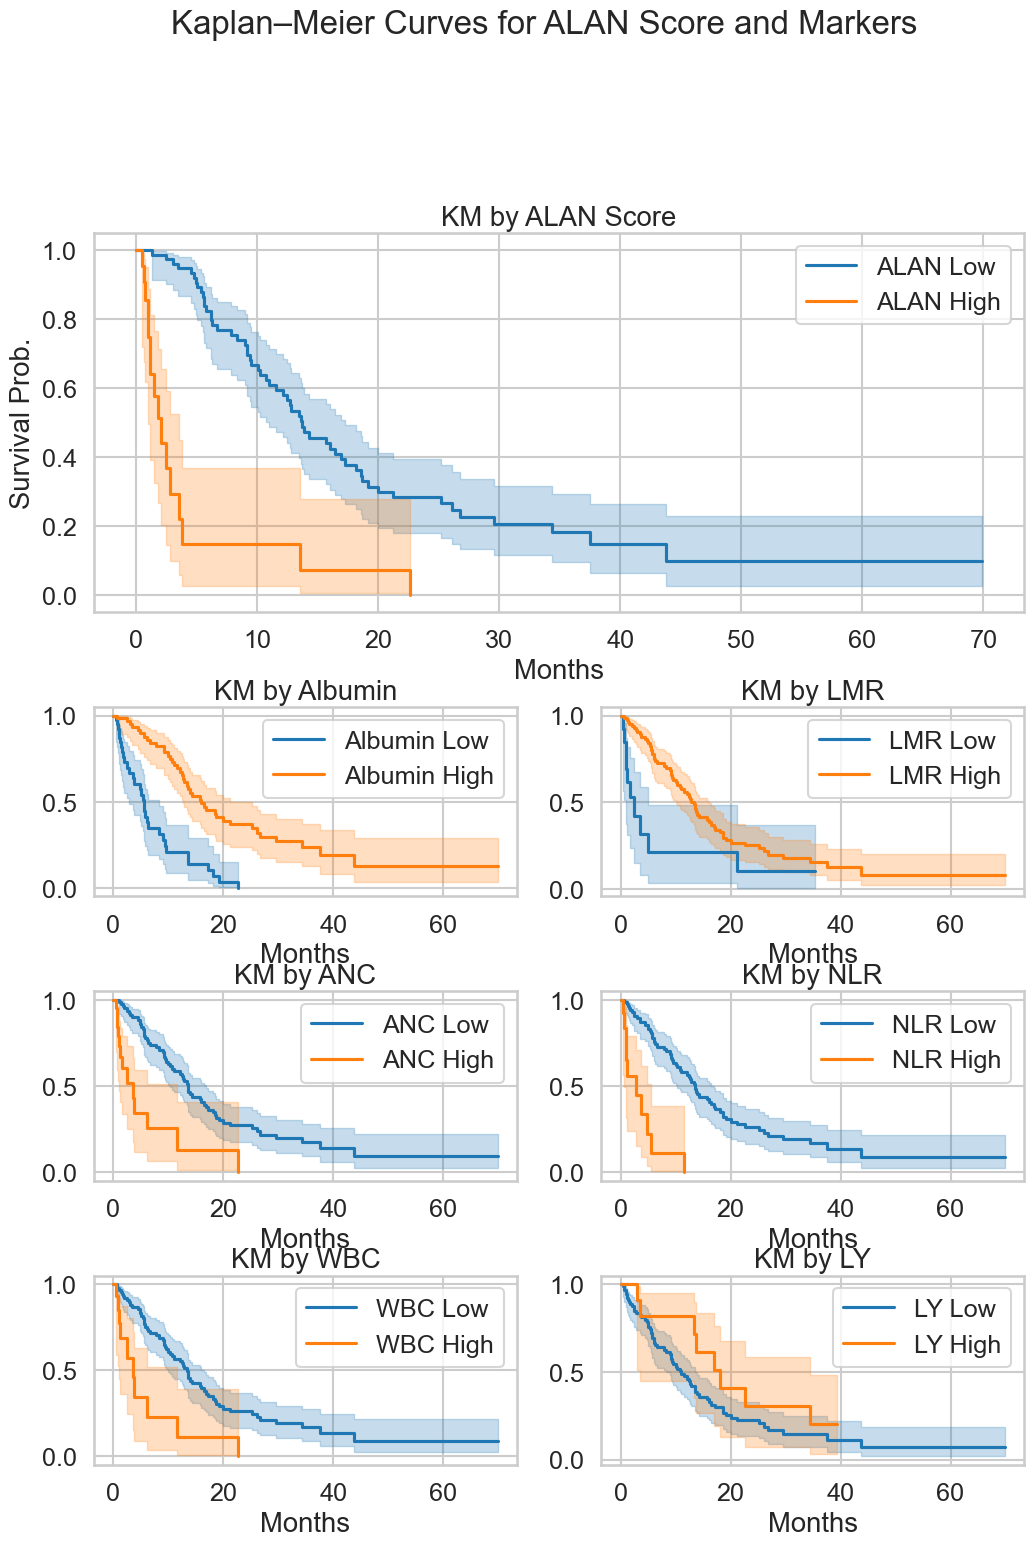

In [12]:
kmf = KaplanMeierFitter()
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(12,16))
gs = gridspec.GridSpec(4,2, height_ratios=[2,1,1,1], hspace=0.4)

# ALAN Score KM
ax = fig.add_subplot(gs[0,:])
for flag in [0,1]:
    sub = df[df['Prognostic_Score_ALAN_flag']==flag]
    kmf.fit(sub['time_diff_months'], sub['Event_Status'], label=f"ALAN {'High' if flag else 'Low'}")
    kmf.plot_survival_function(ax=ax)
ax.set(title='KM by ALAN Score', xlabel='Months', ylabel='Survival Prob.')

# Individual markers (first 6 as example)
for i,var in enumerate(vars_to_cut[:6]):
    ax = fig.add_subplot(gs[1 + i//2, i%2])
    for flag in [0,1]:
        sub = df[df[f"{var}_flag"]==flag]
        kmf.fit(sub['time_diff_months'], sub['Event_Status'], label=f"{var} {'High' if flag else 'Low'}")
        kmf.plot(ax=ax)
    ax.set(title=f'KM by {var}', xlabel='Months', ylabel='')
plt.suptitle('Kaplan–Meier Curves for ALAN Score and Markers', y=1.02)
plt.tight_layout()

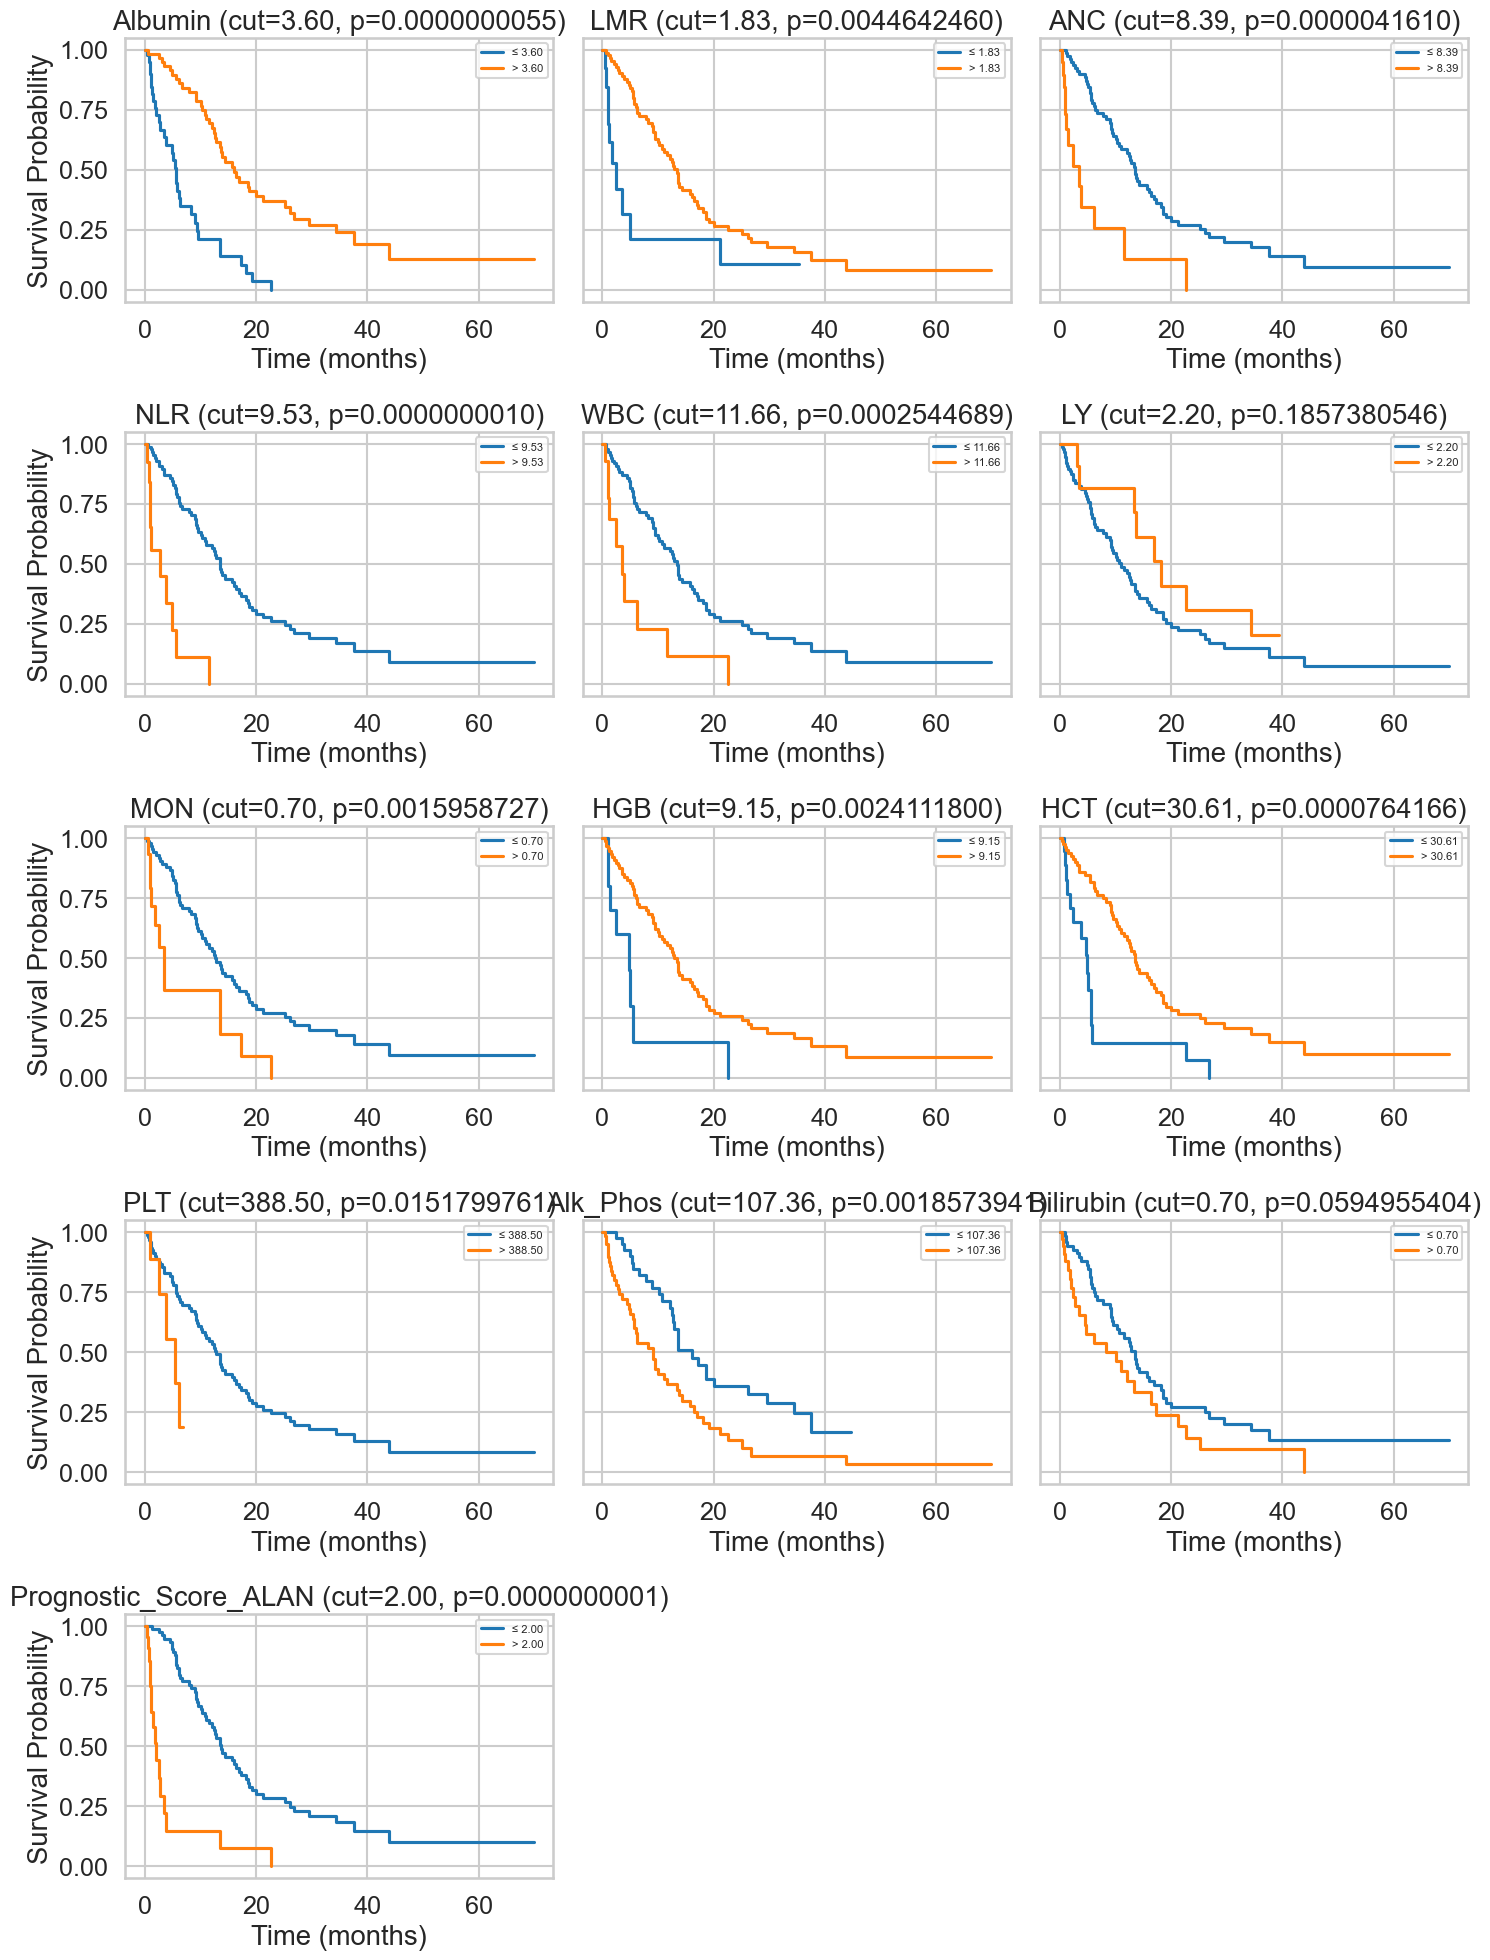

In [13]:
# Kaplan–Meier Curves in a Grid with Cutpoint Values and Log‑Rank p‑Values

import math
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

# List of variables to plot
vars_to_plot = vars_to_cut

# Determine grid size
n = len(vars_to_plot)
cols = 3
rows = math.ceil(n / cols)

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows), sharey=True)
axes = axes.flatten()

# Plot each variable
for i, var in enumerate(vars_to_plot):
    ax = axes[i]

    # Retrieve cutpoint
    cut = cutpoints[var]

    # Split into low/high based on cutpoint
    group_low = df[df[var] <= cut]
    group_high = df[df[var] > cut]

    # Fit KM models
    kmf_low = KaplanMeierFitter()
    kmf_high = KaplanMeierFitter()
    kmf_low.fit(group_low['time_diff_months'],
                group_low['Event_Status'],  label=f"≤ {cut:.2f}")
    kmf_high.fit(group_high['time_diff_months'],
                 group_high['Event_Status'], label=f"> {cut:.2f}")

    # Plot survival functions
    kmf_low.plot_survival_function(ax=ax, ci_show=False)
    kmf_high.plot_survival_function(ax=ax, ci_show=False)

    # Compute log‐rank p‐value
    lr = logrank_test(
        group_low['time_diff_months'], group_high['time_diff_months'],
        event_observed_A=group_low['Event_Status'],
        event_observed_B=group_high['Event_Status']
    )
    pval = lr.p_value

    # Annotate title with cutpoint and p-value
    ax.set_title(f"{var} (cut={cut:.2f}, p={pval:.10f})")
    ax.set_xlabel("Time (months)")
    ax.set_ylabel("Survival Probability")
    ax.legend(fontsize=8)

# Turn off any unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [14]:
# 3. Multivariate Cox Proportional Hazards Model

from lifelines import CoxPHFitter

# Build DataFrame with all flags + Age and Sex
flag_cols = [f"{var}_flag" for var in vars_to_cut]
mv_df = df[['time_diff_months', 'Event_Status',
            'Age', 'Gender_bin'] + flag_cols].copy()

# Fit multivariate CoxPH
cph_mv = CoxPHFitter()
cph_mv.fit(mv_df, duration_col='time_diff_months', event_col='Event_Status')
cph_mv.print_summary()

<lifelines.CoxPHFitter: fitted with 106 total observations, 34 right-censored observations>
             duration col = 'time_diff_months'
                event col = 'Event_Status'
      baseline estimation = breslow
   number of observations = 106
number of events observed = 72
   partial log-likelihood = -236.60
         time fit was run = 2025-04-18 06:32:59 UTC

---
                            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                   
Age                        -0.01      0.99      0.01           -0.04            0.02                0.96                1.02
Gender_bin                  0.34      1.41      0.28           -0.20            0.89                0.82                2.44
Albumin_flag               -1.11      0.33      0.35           -1.80           -0.43                0.17                0.65
LMR_flag                   -0.80      0.45      0.40           -1.58           -0.03                0.21                0.97
ANC_flag                    1.50      4.48      0.74            0.05            2.96                1.05               19.21
NLR_flag                    1.36      3.89      0.52            0.34            2.38                1.40               10.80
WBC_flag                   -1.89      0.15      0.87           -3.60           -0.18                0.03                0.83
LY_flag                    -0.73      0.48      0.50           -1.70            0.25                0.18                1.28
MON_flag                   -0.27      0.76      0.62           -1.49            0.94                0.23                2.56
HGB_flag                   -0.04      0.96      0.63           -1.27            1.19                0.28                3.30
HCT_flag                   -0.44      0.64      0.47           -1.36            0.47                0.26                1.60
PLT_flag                    0.20      1.22      0.59           -0.96            1.35                0.38                3.87
Alk_Phos_flag               0.43      1.54      0.30           -0.15            1.01                0.86                2.76
Bilirubin_flag             -0.01      0.99      0.31           -0.62            0.60                0.54                1.82
Prognostic_Score_ALAN_flag  1.10      3.00      0.59           -0.06            2.26                0.95                9.54

                            cmp to     z      p  -log2(p)
covariate                                                
Age                           0.00 -0.83   0.40      1.31
Gender_bin                    0.00  1.23   0.22      2.20
Albumin_flag                  0.00 -3.18 <0.005      9.40
LMR_flag                      0.00 -2.02   0.04      4.54
ANC_flag                      0.00  2.02   0.04      4.53
NLR_flag                      0.00  2.61   0.01      6.78
WBC_flag                      0.00 -2.17   0.03      5.06
LY_flag                       0.00 -1.46   0.14      2.80
MON_flag                      0.00 -0.44   0.66      0.60
HGB_flag                      0.00 -0.06   0.95      0.07
HCT_flag                      0.00 -0.95   0.34      1.55
PLT_flag                      0.00  0.33   0.74      0.43
Alk_Phos_flag                 0.00  1.47   0.14      2.82
Bilirubin_flag                0.00 -0.04   0.97      0.05
Prognostic_Score_ALAN_flag    0.00  1.87   0.06      4.01
---
Concordance = 0.77
Partial AIC = 503.20
log-likelihood ratio test = 68.32 on 15 df
-log2(p) of ll-ratio test = 26.75

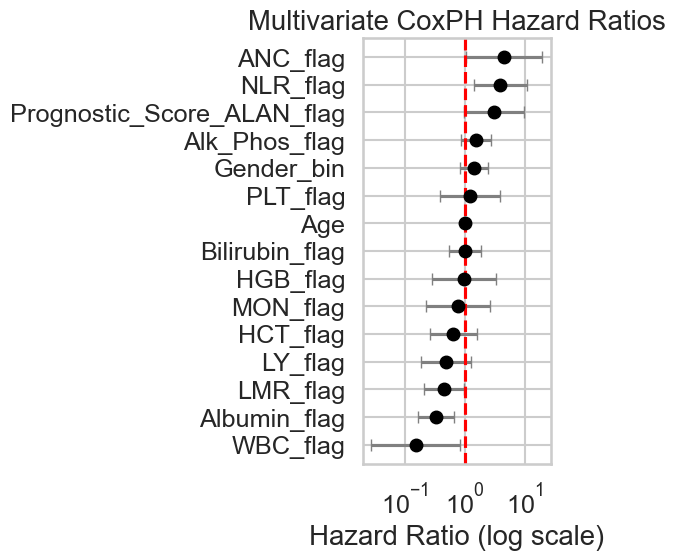

In [15]:
# 1. Multivariate CoxPH Forest Plot
import matplotlib.pyplot as plt
import numpy as np

# Extract and sort summary
summary_df = cph_mv.summary.reset_index()
summary_df['HR'] = summary_df['exp(coef)']
summary_df['CI_lower'] = summary_df['exp(coef) lower 95%']
summary_df['CI_upper'] = summary_df['exp(coef) upper 95%']
summary_df = summary_df.sort_values('HR')

# Plot
fig, ax = plt.subplots(figsize=(6, len(summary_df) * 0.4))
y = np.arange(len(summary_df))
ax.errorbar(summary_df['HR'], y,
            xerr=[summary_df['HR'] - summary_df['CI_lower'],
                  summary_df['CI_upper'] - summary_df['HR']],
            fmt='o', color='black', ecolor='gray', capsize=4)
ax.axvline(1, color='red', linestyle='--')
ax.set_yticks(y)
ax.set_yticklabels(summary_df['covariate'])
ax.set_xscale('log')
ax.set_xlabel('Hazard Ratio (log scale)')
ax.set_title('Multivariate CoxPH Hazard Ratios')
plt.tight_layout()
plt.show()

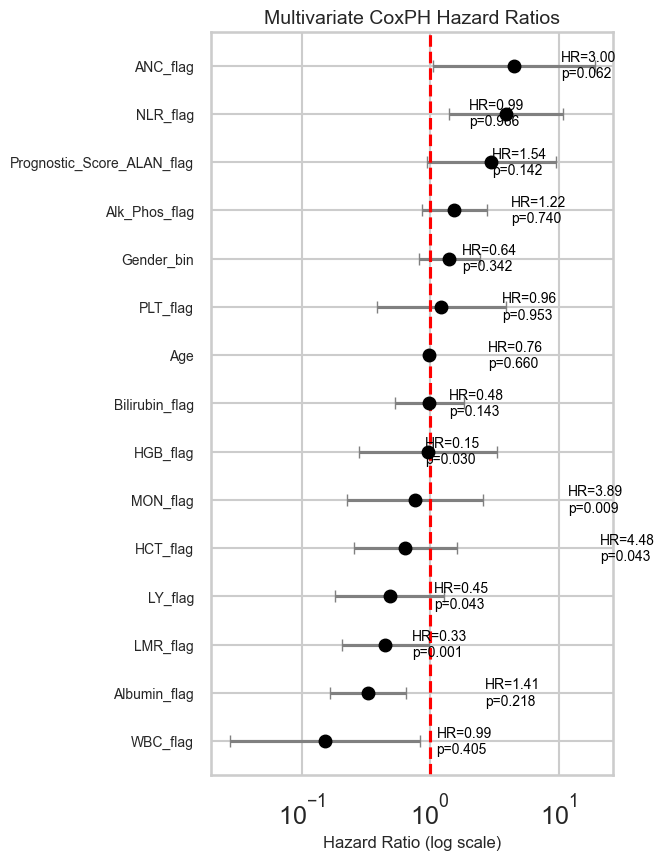

In [16]:
# 1. Multivariate CoxPH Forest Plot with Readable Annotations

import matplotlib.pyplot as plt
import numpy as np

# Extract and sort summary
summary_df = cph_mv.summary.reset_index()
summary_df['HR'] = summary_df['exp(coef)']
summary_df['CI_low'] = summary_df['exp(coef) lower 95%']
summary_df['CI_high'] = summary_df['exp(coef) upper 95%']
summary_df['p'] = summary_df['p']
summary_df.sort_values('HR', inplace=True)

fig, ax = plt.subplots(figsize=(7, summary_df.shape[0]*0.6))
y = np.arange(len(summary_df))

ax.errorbar(
    summary_df['HR'], y,
    xerr=[summary_df['HR']-summary_df['CI_low'],
          summary_df['CI_high']-summary_df['HR']],
    fmt='o', color='black', ecolor='gray', capsize=4
)

# Reference line
ax.axvline(1, color='red', linestyle='--')

# Annotate each point with HR & p-value
for i, row in summary_df.iterrows():
    x_text = row['CI_high'] * 1.1  # place right of CI
    ax.text(
        x_text, y[i],
        f"HR={row['HR']:.2f}\np={row['p']:.3f}",
        va='center', ha='left', fontsize=10, color='black'
    )

ax.set_yticks(y)
ax.set_yticklabels(summary_df['covariate'], fontsize=10)
ax.set_xscale('log')
ax.set_xlabel('Hazard Ratio (log scale)', fontsize=12)
ax.set_title('Multivariate CoxPH Hazard Ratios', fontsize=14)
plt.tight_layout()
plt.show()

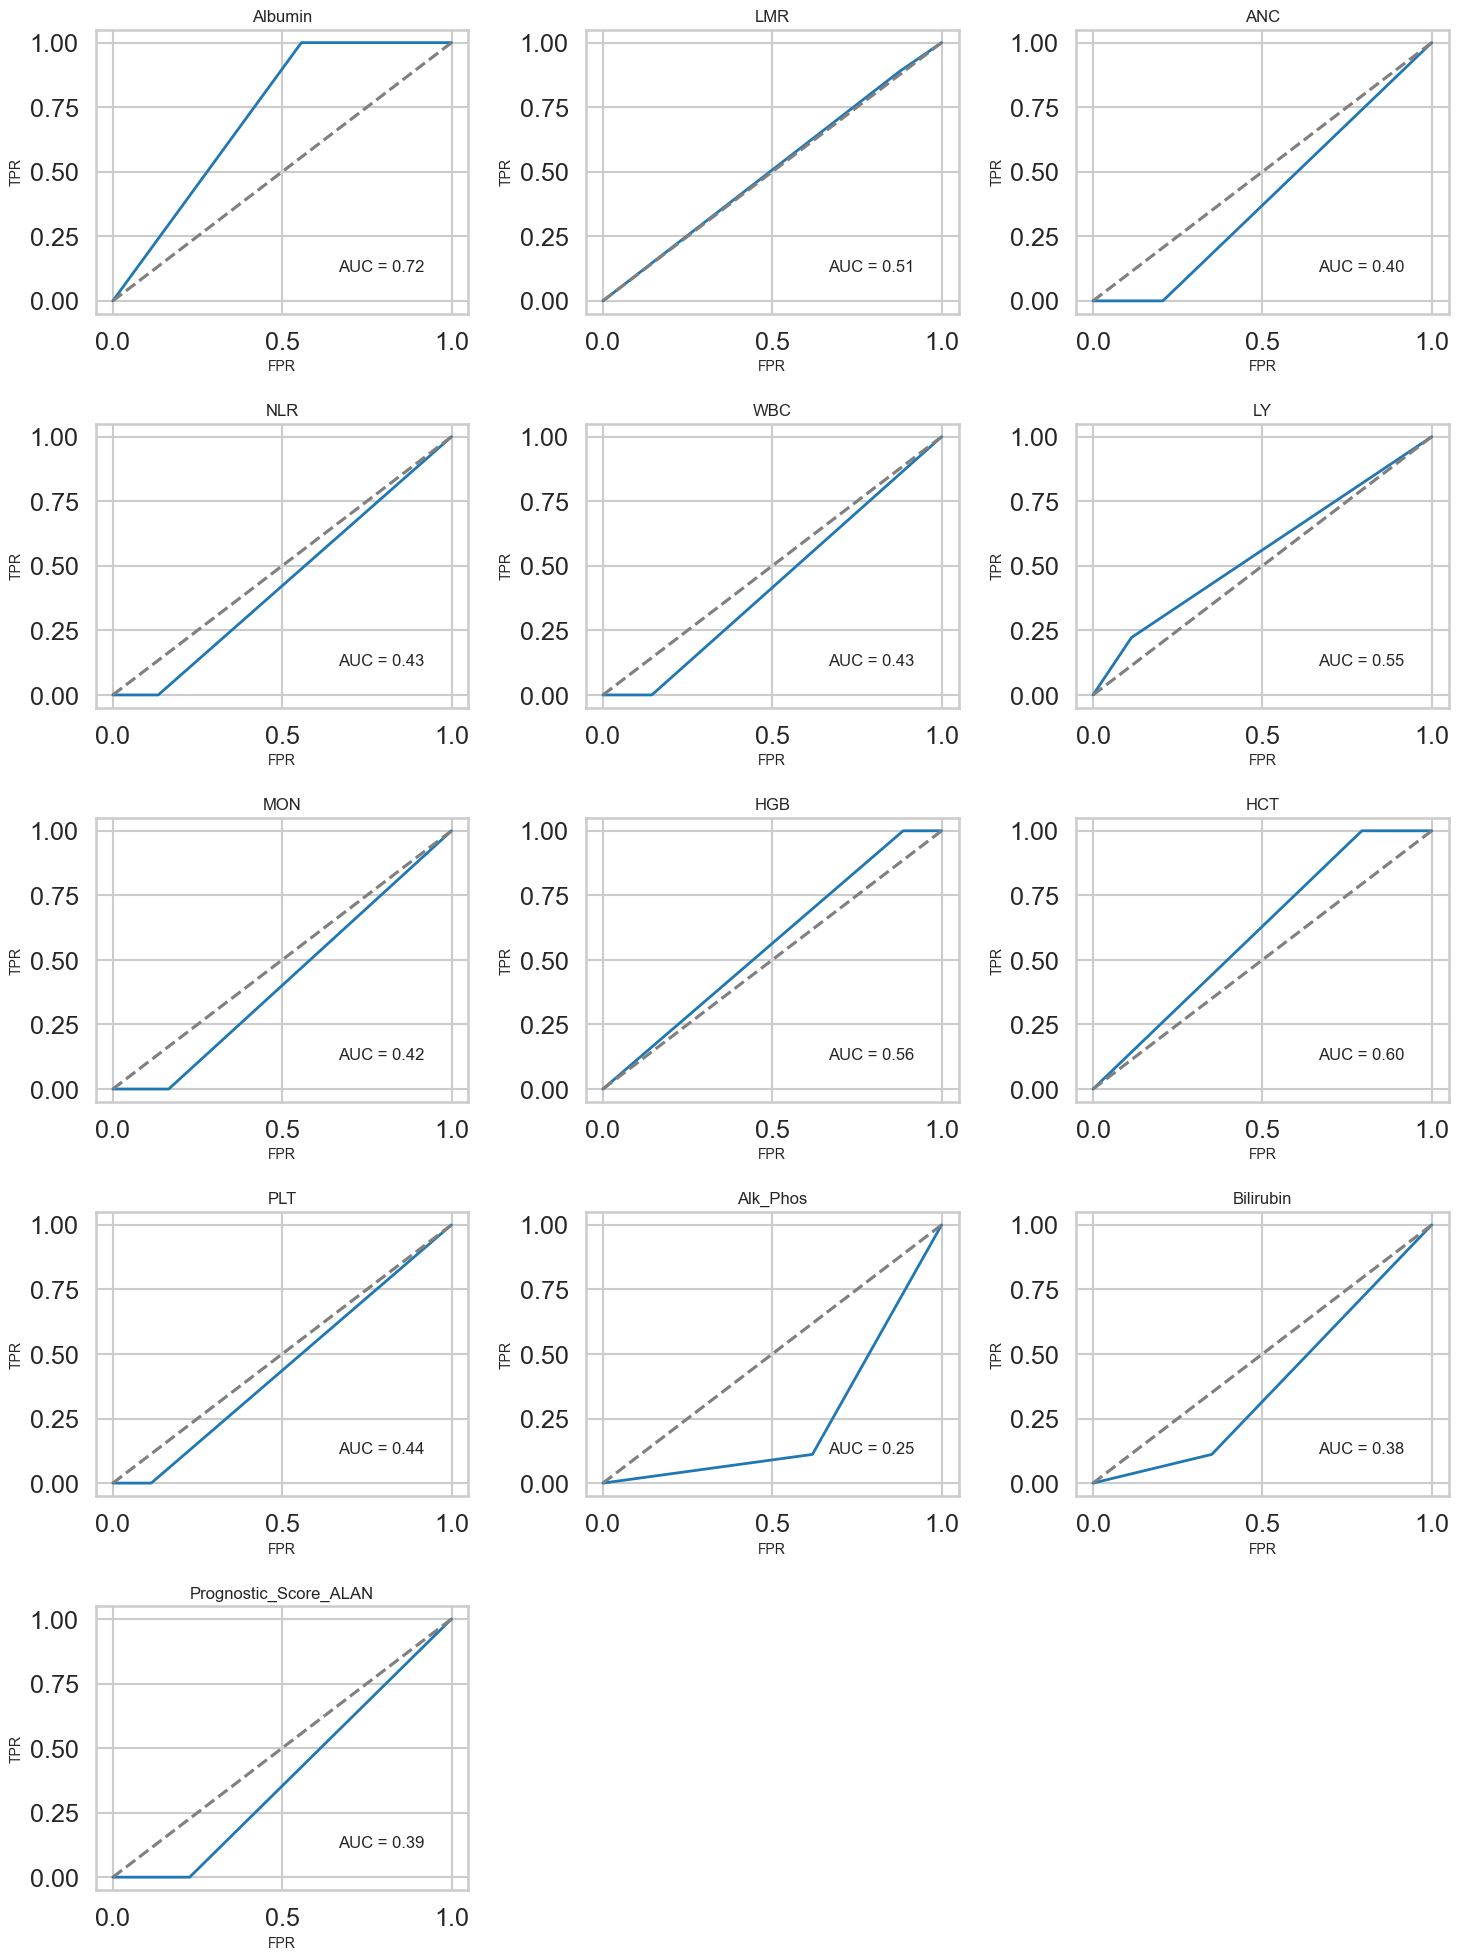

In [17]:
# 2. ROC Curves in a Grid with Larger AUC Annotations

import math
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

flags = [f"{v}_flag" for v in vars_to_cut]
n = len(flags)
cols = 3
rows = math.ceil(n/cols)

fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
axes = axes.flatten()

for i, var in enumerate(flags):
    ax = axes[i]
    y_true = df['surv_24']
    y_score = df[var]
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, lw=2)
    ax.plot([0, 1], [0, 1], linestyle='--', color='gray')
    # Annotate AUC in top right corner
    ax.text(
        0.65, 0.15, f"AUC = {roc_auc:.2f}",
        transform=ax.transAxes, fontsize=12,
        bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.7)
    )
    ax.set_title(var.replace('_flag', ''), fontsize=12)
    ax.set_xlabel('FPR', fontsize=10)
    ax.set_ylabel('TPR', fontsize=10)

# Turn off unused axes
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

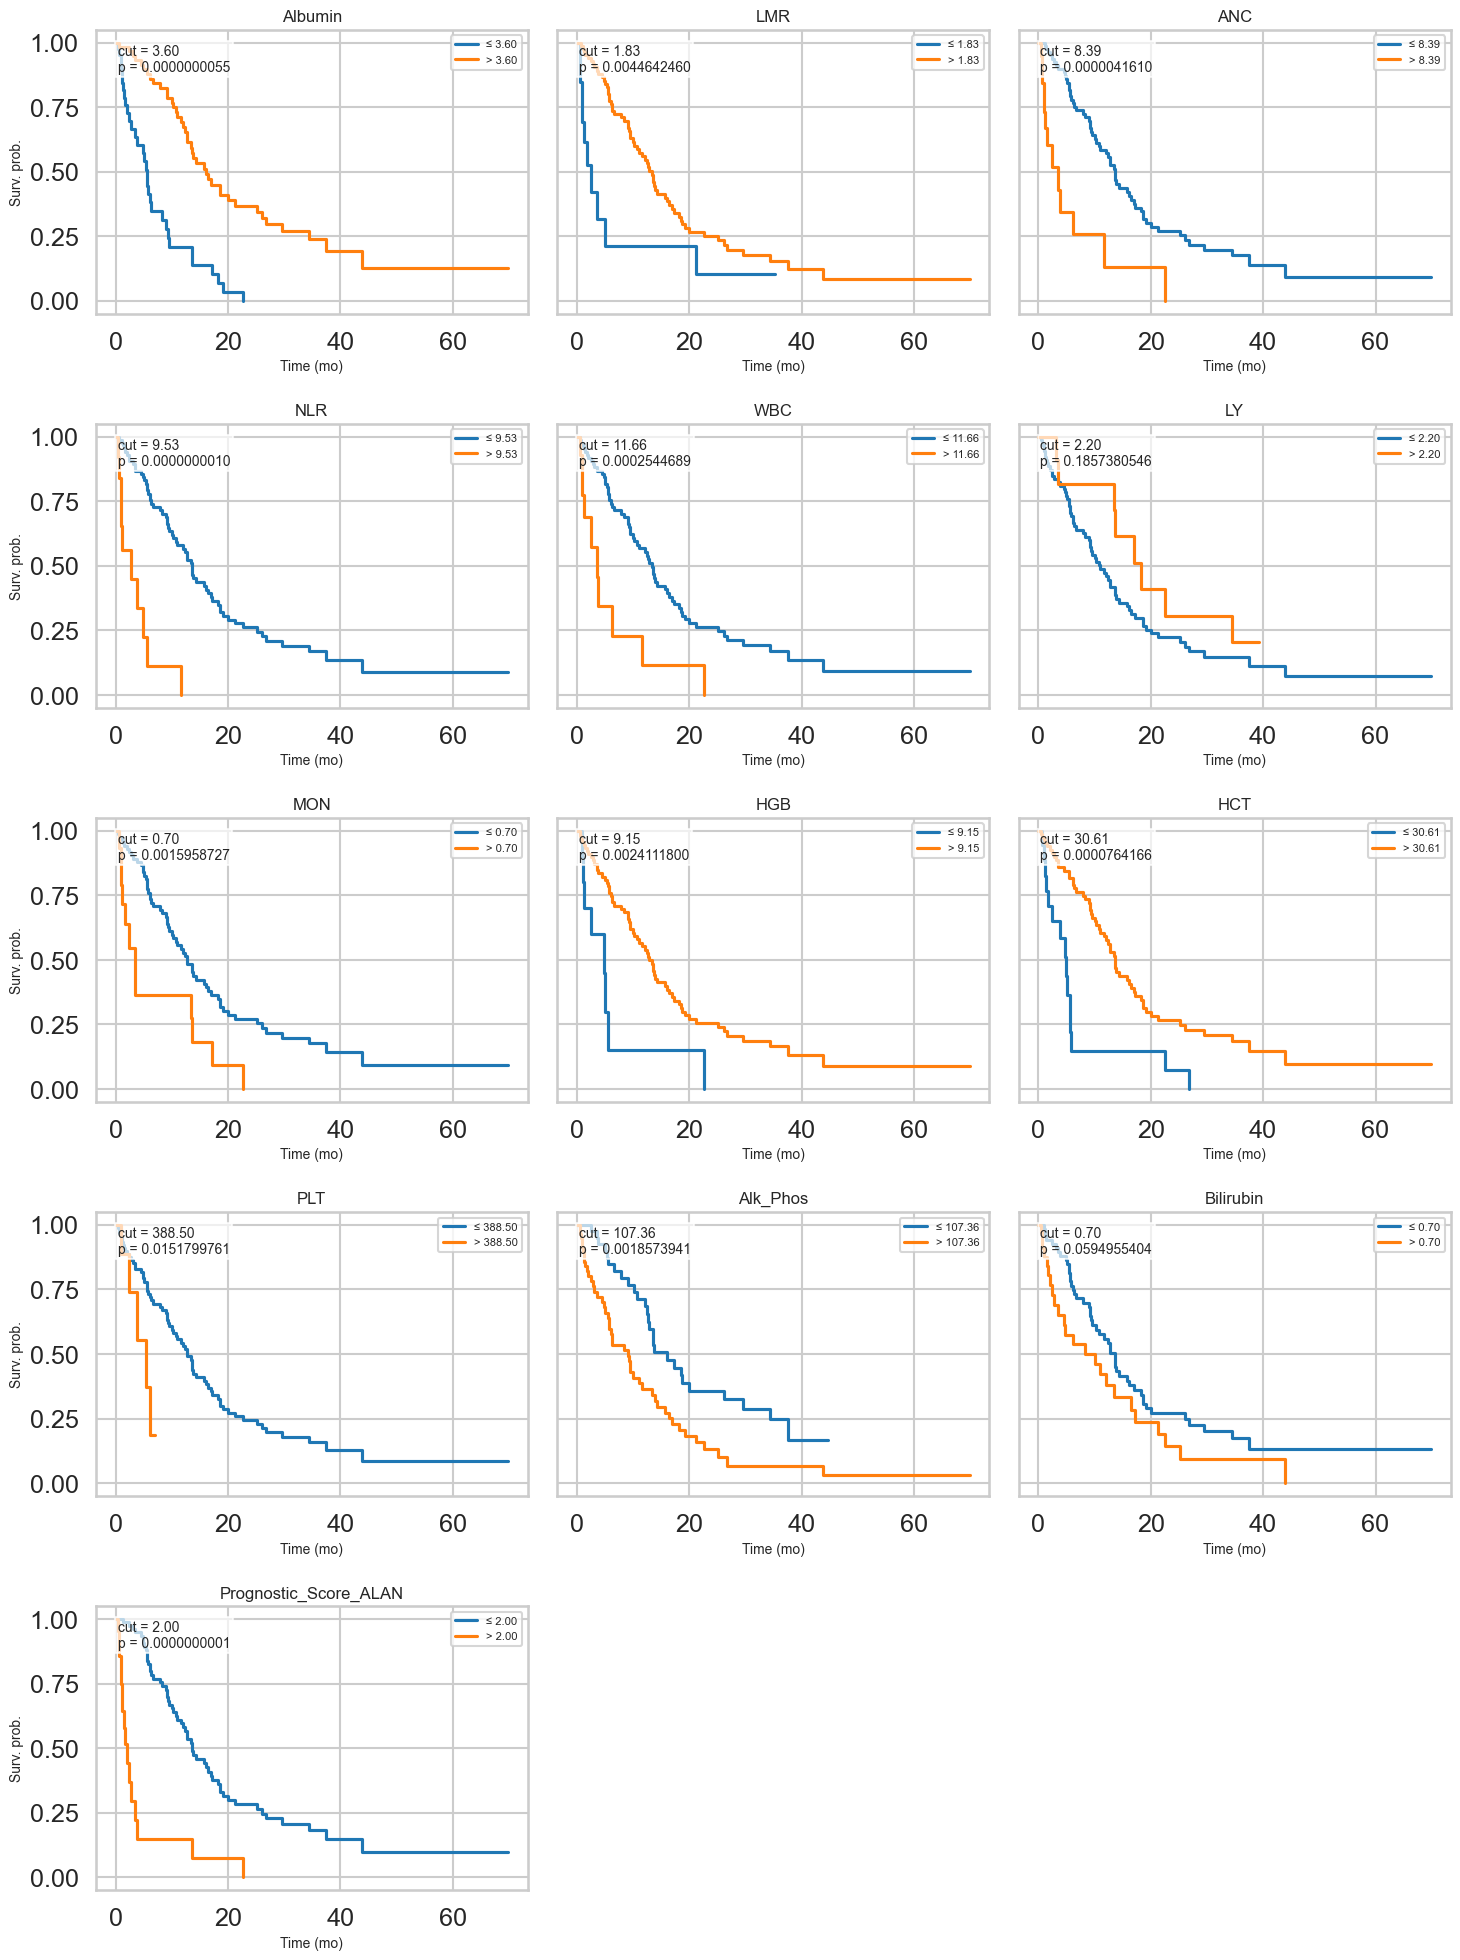

In [18]:
# 3. Kaplan–Meier Curves Grid with Cutpoint & p‑Value Annotations

import math
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

kmf = KaplanMeierFitter()
n = len(vars_to_cut)
cols = 3
rows = math.ceil(n/cols)

fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows), sharey=True)
axes = axes.flatten()

for i, var in enumerate(vars_to_cut):
    ax = axes[i]
    cut = cutpoints[var]
    low = df[df[var] <= cut]
    high = df[df[var] > cut]
    # Fit and plot
    kmf.fit(low['time_diff_months'], low['Event_Status'], label=f"≤ {cut:.2f}")
    kmf.plot_survival_function(ax=ax, ci_show=False)
    kmf.fit(high['time_diff_months'],
            high['Event_Status'], label=f"> {cut:.2f}")
    kmf.plot_survival_function(ax=ax, ci_show=False)
    # Log-rank
    p = logrank_test(
        low['time_diff_months'], high['time_diff_months'],
        event_observed_A=low['Event_Status'], event_observed_B=high['Event_Status']
    ).p_value
    # Annotate
    ax.text(
        0.05, 0.95, f"cut = {cut:.2f}\np = {p:.10f}",
        transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7, pad=2)
    )
    ax.set_title(var, fontsize=12)
    ax.set_xlabel('Time (mo)', fontsize=10)
    ax.set_ylabel('Surv. prob.', fontsize=10)
    ax.legend(fontsize=8)

# Turn off extra axes
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

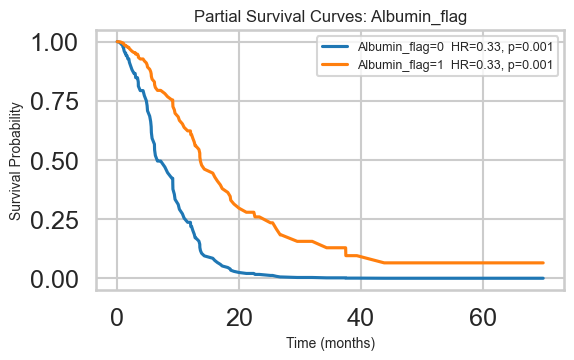

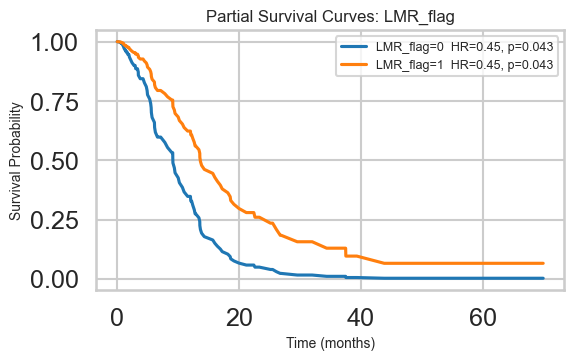

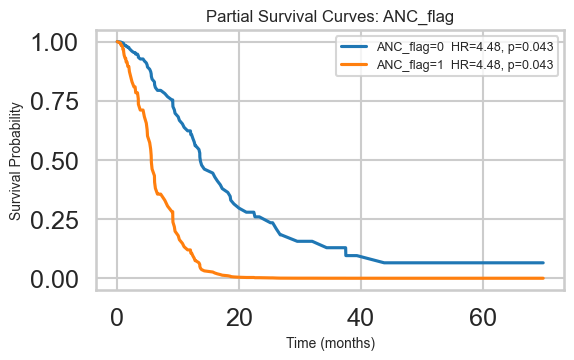

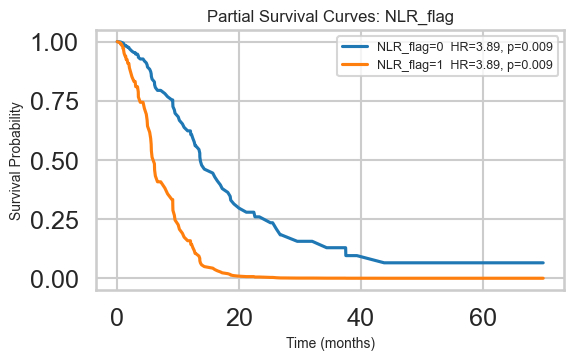

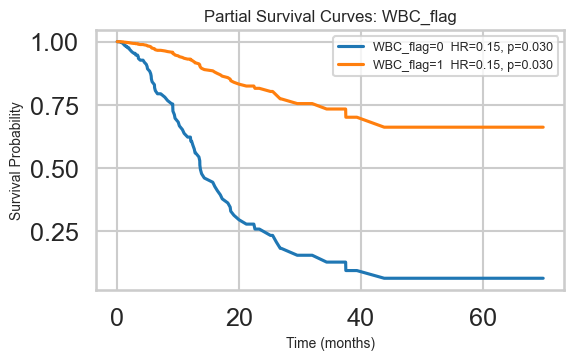

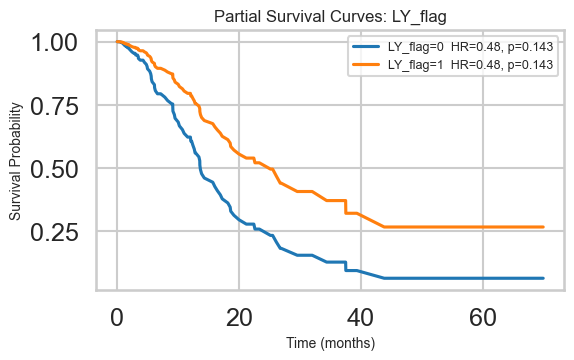

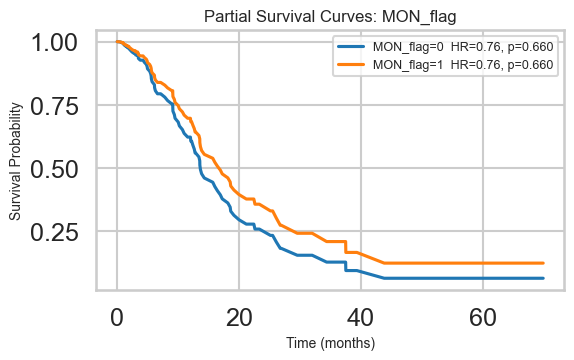

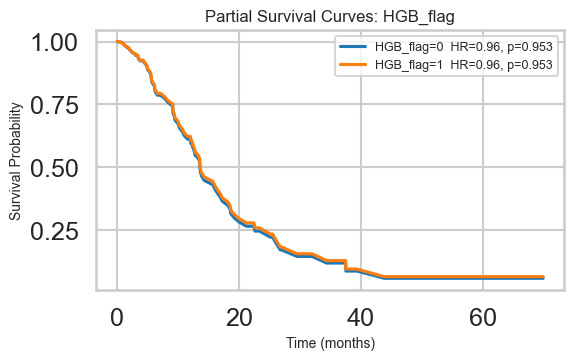

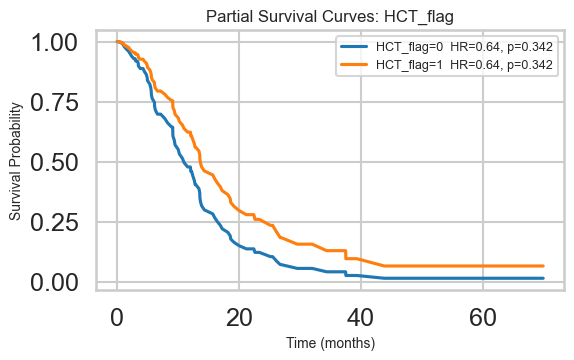

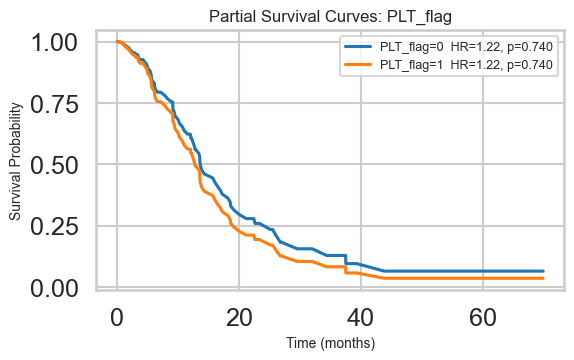

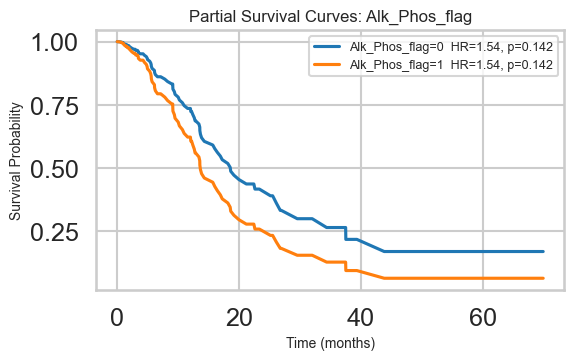

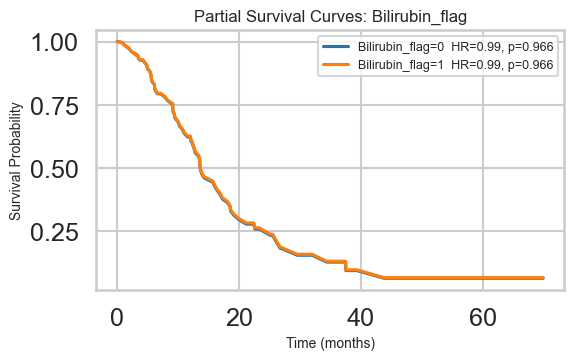

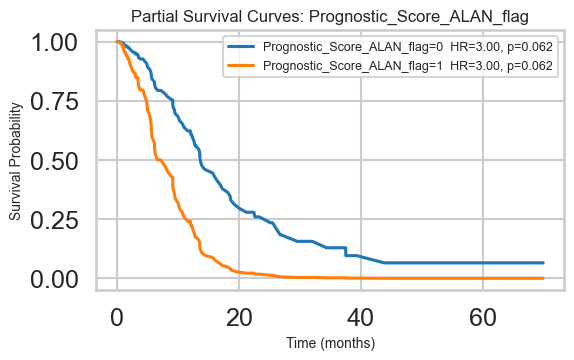

In [19]:
# 4. Partial Effect Curves with HR & p‑Value in Legend

import matplotlib.pyplot as plt

# Generate a single base profile at median
base = mv_df.median().to_frame().T
summ = cph_mv.summary

for flag in [f"{v}_flag" for v in vars_to_cut]:
    plt.figure(figsize=(6, 4))
    lines = []
    for val in [0, 1]:
        prof = base.copy()
        prof[flag] = val
        sf = cph_mv.predict_survival_function(prof)
        hr = float(np.exp(cph_mv.params_[flag]))
        p = float(summ.loc[flag, 'p'])
        label = f"{flag}={val}  HR={hr:.2f}, p={p:.3f}"
        line, = plt.plot(sf.index, sf.values.flatten(), label=label)
        lines.append(line)
    plt.title(f'Partial Survival Curves: {flag}', fontsize=12)
    plt.xlabel('Time (months)', fontsize=10)
    plt.ylabel('Survival Probability', fontsize=10)
    plt.legend(fontsize=9)
    plt.tight_layout()
    plt.show()

c:\Users\ajboo\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\axisgrid.py:1513: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=vector, **plot_kwargs)
c:\Users\ajboo\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\axisgrid.py:1513: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=vector, **plot_kwargs)
c:\Users\ajboo\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\axisgrid.py:1513: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=vector, **plot_kwargs)
c:\Users\ajboo\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\axisgrid.py:1513: FutureWarning: 

`shade` is now deprecat

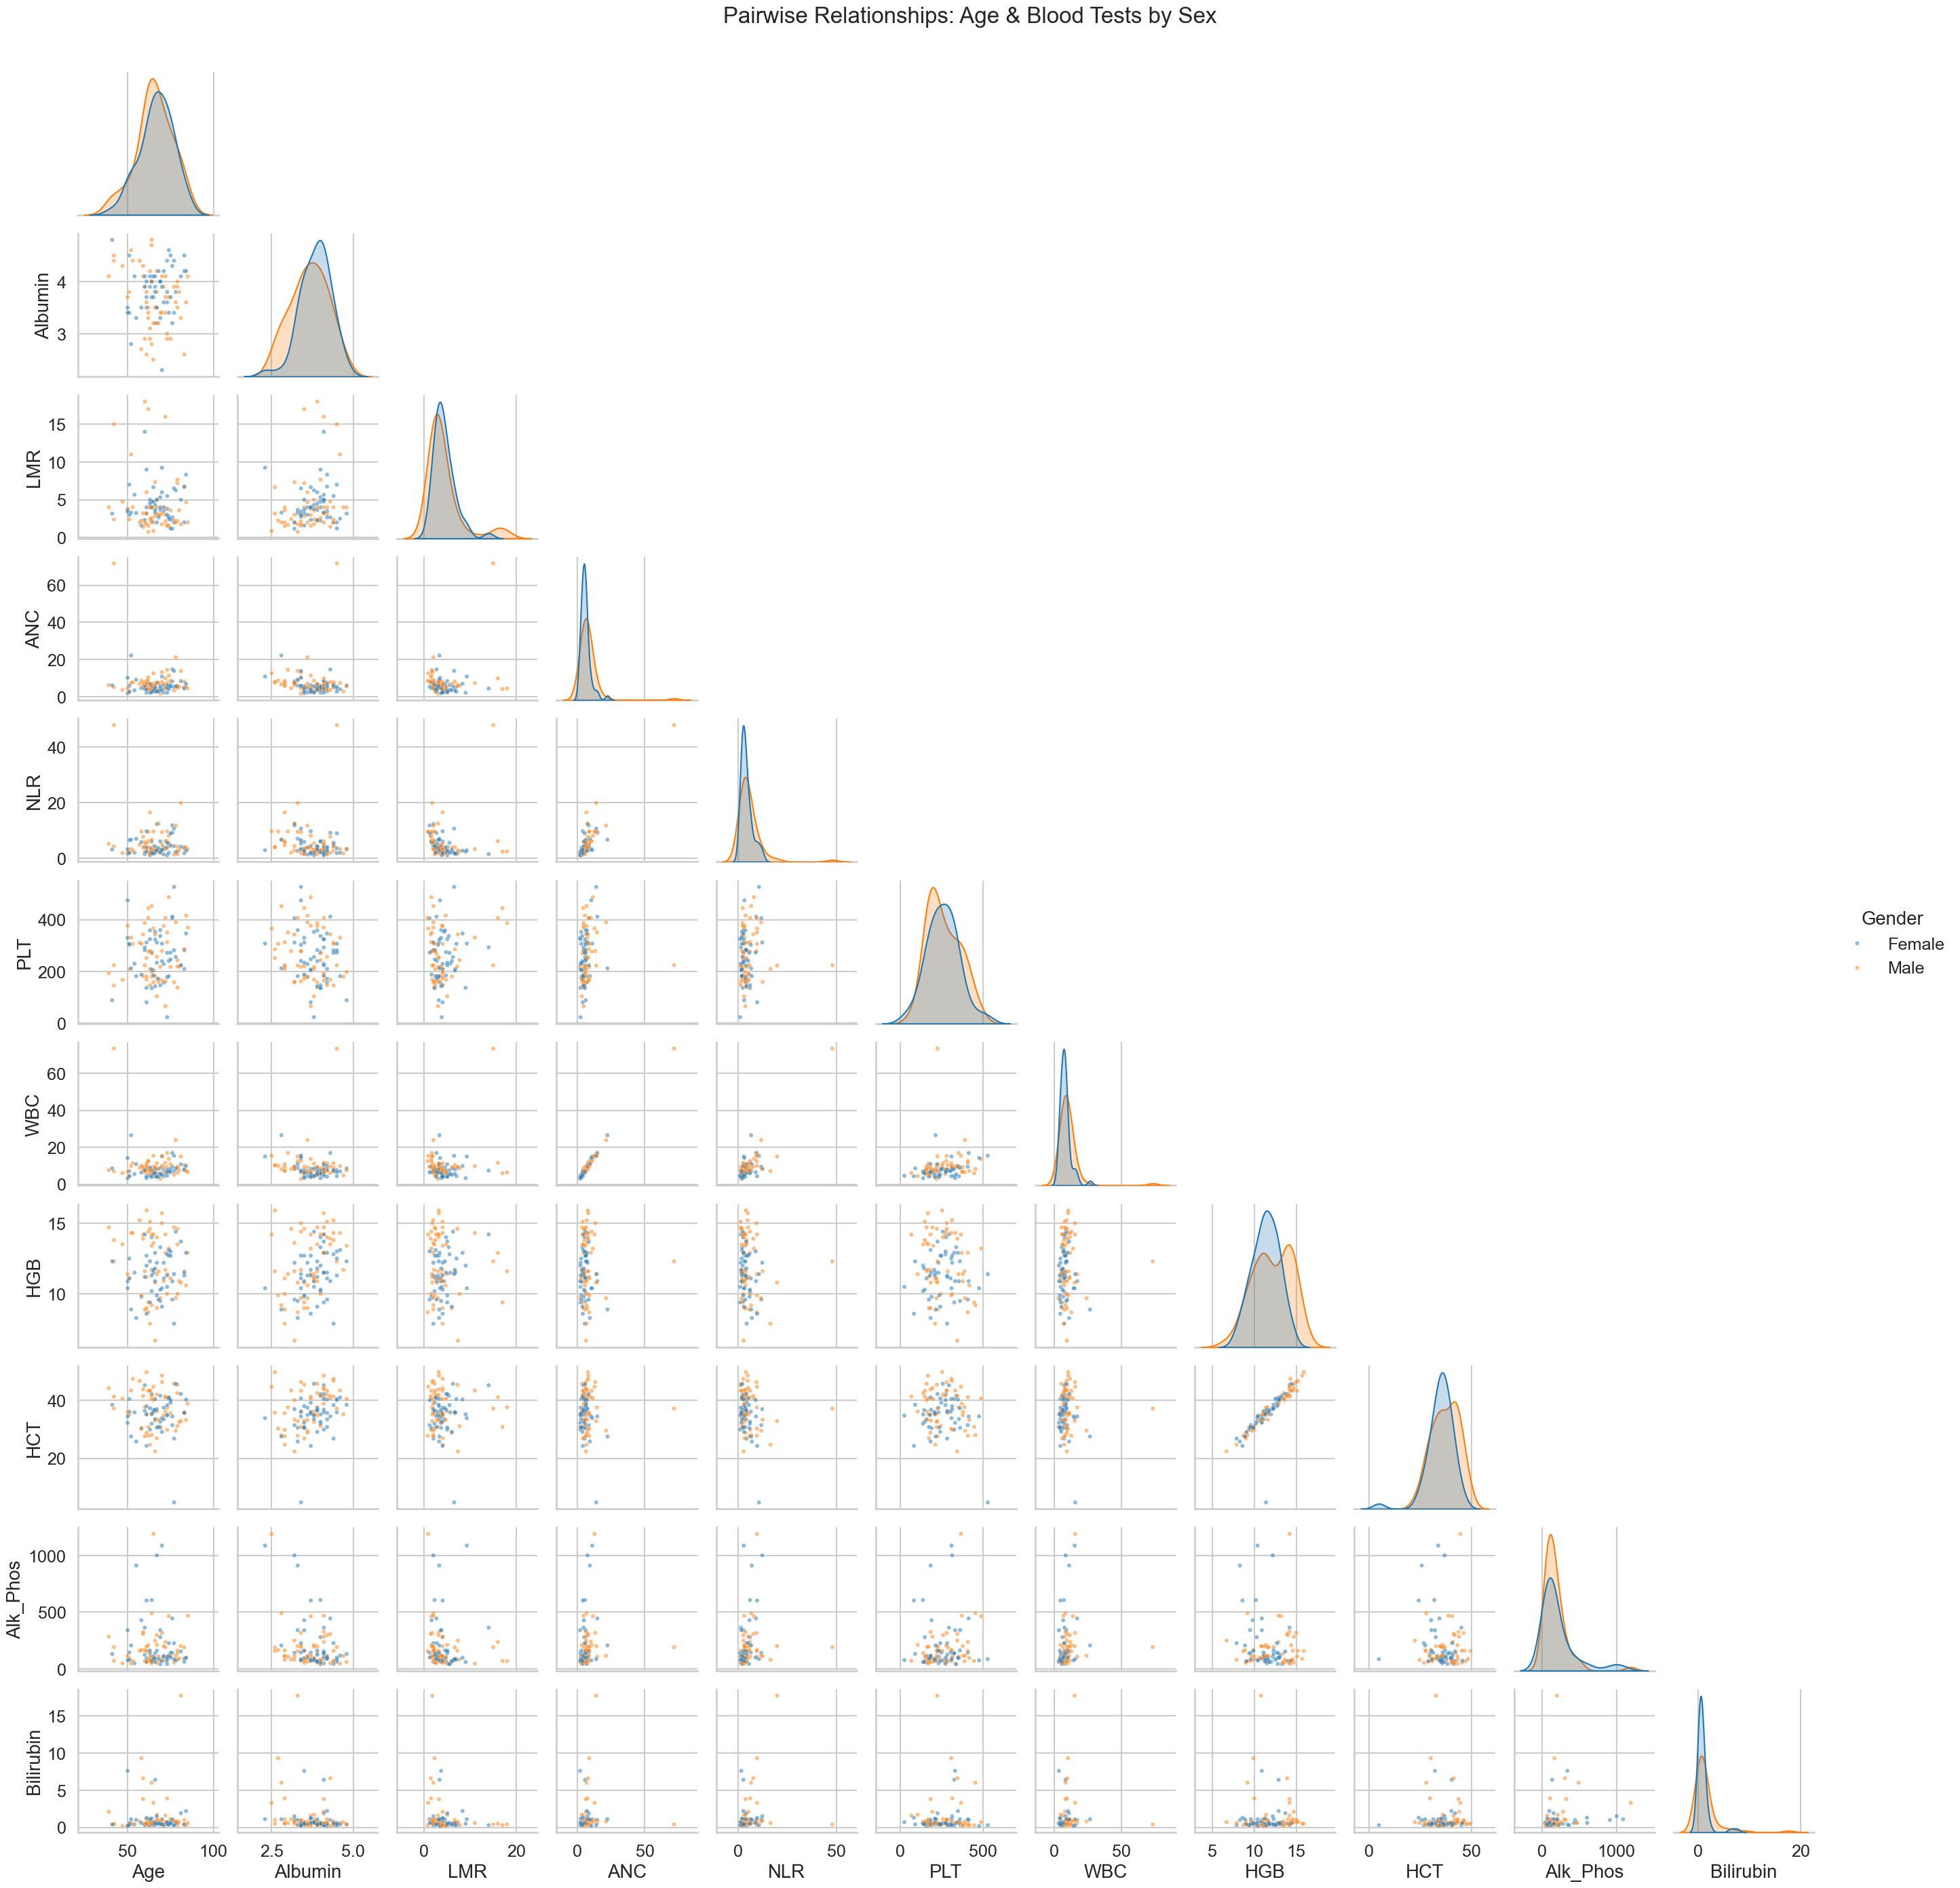

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select the continuous variables plus Age, colored by Sex
cont = ['Age', 'Albumin', 'LMR', 'ANC', 'NLR', 'PLT',
        'WBC', 'HGB', 'HCT', 'Alk_Phos', 'Bilirubin']
sns.pairplot(df[cont + ['Gender']], hue='Gender', diag_kind='kde', corner=True,
             plot_kws={'alpha': 0.5, 's': 20}, diag_kws={'shade': True})
plt.suptitle("Pairwise Relationships: Age & Blood Tests by Sex", y=1.02)
plt.show()

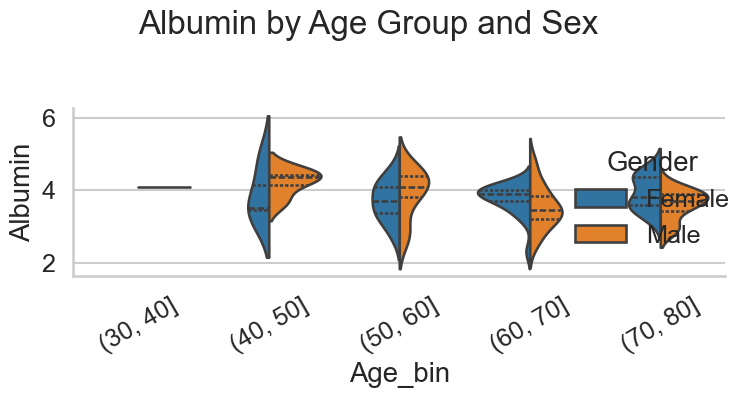

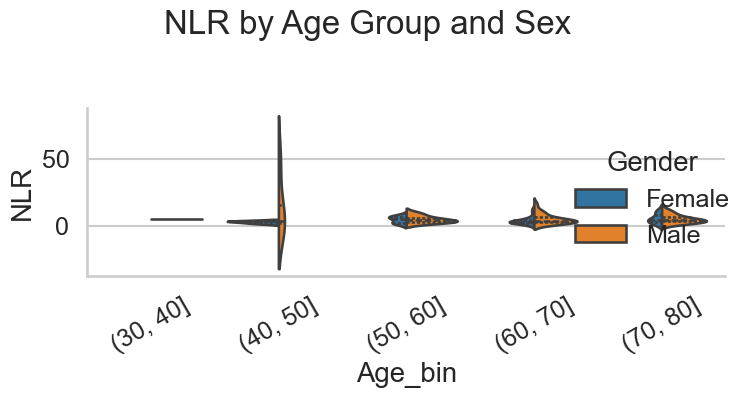

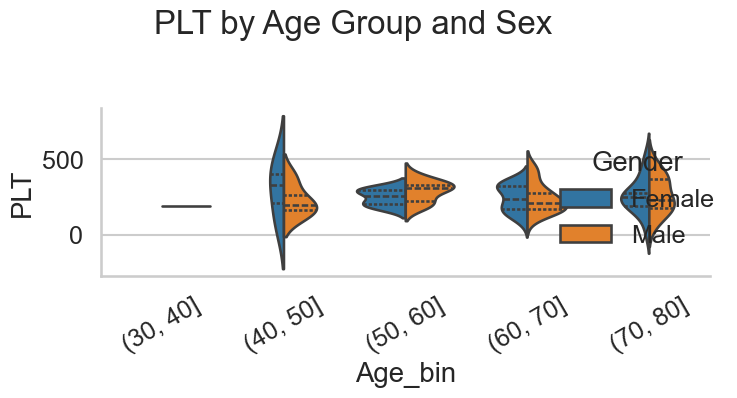

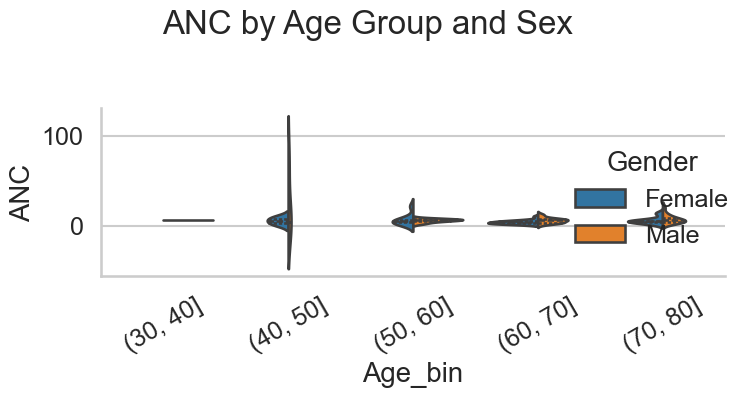

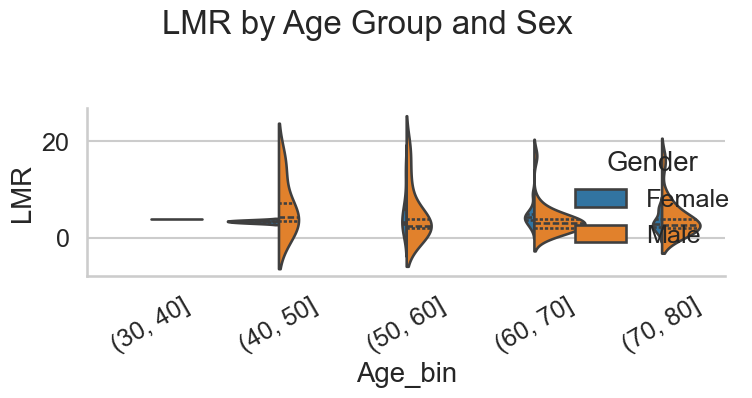

In [21]:
# Create age groups (e.g. 0–10, 10–20,… or your W‑year bins)
import seaborn as sns
import matplotlib.pyplot as plt
df['Age_bin'] = pd.cut(df['Age'], bins=np.arange(
    30, 90, 10))  # adjust to your range


for var in ['Albumin', 'NLR', 'PLT', 'ANC', 'LMR']:
    g = sns.catplot(x='Age_bin', y=var, hue='Gender', kind='violin',
                    split=True, inner='quartile', data=df,
                    height=4, aspect=1.5)
    g.set_xticklabels(rotation=30)
    g.fig.suptitle(f"{var} by Age Group and Sex", y=1.02)
    plt.tight_layout()
    plt.show()

C:\Users\ajboo\AppData\Local\Temp\ipykernel_38476\2523952308.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(x='Age', y=var, hue='Gender',


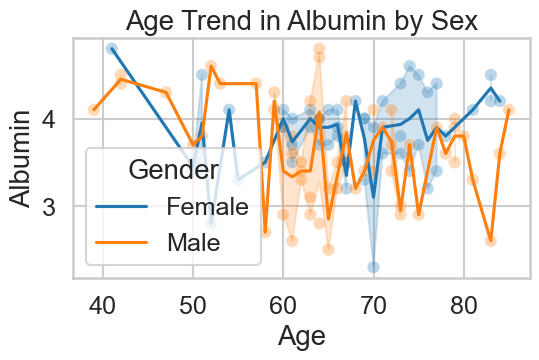

C:\Users\ajboo\AppData\Local\Temp\ipykernel_38476\2523952308.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(x='Age', y=var, hue='Gender',


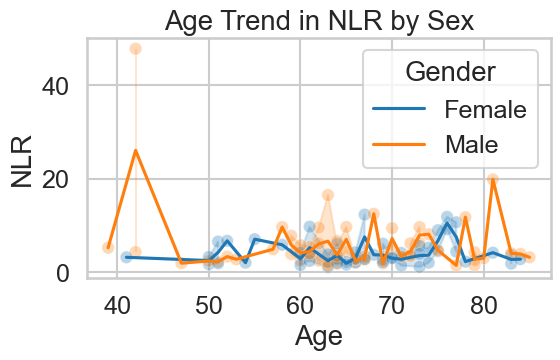

C:\Users\ajboo\AppData\Local\Temp\ipykernel_38476\2523952308.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(x='Age', y=var, hue='Gender',


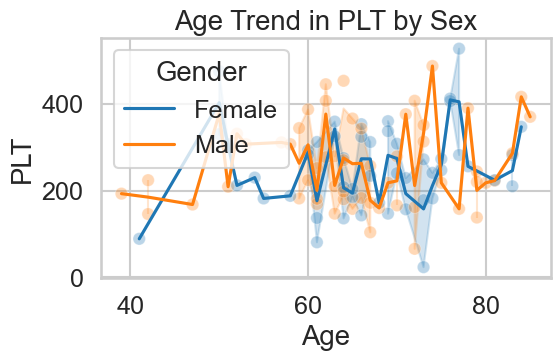

C:\Users\ajboo\AppData\Local\Temp\ipykernel_38476\2523952308.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(x='Age', y=var, hue='Gender',


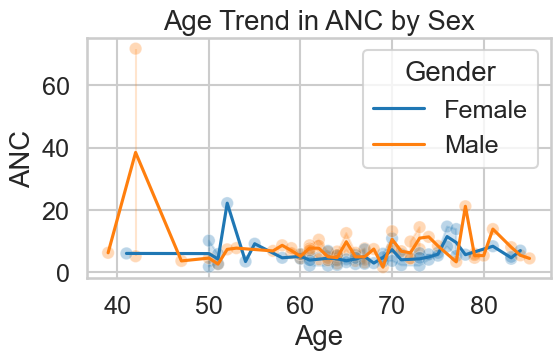

C:\Users\ajboo\AppData\Local\Temp\ipykernel_38476\2523952308.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(x='Age', y=var, hue='Gender',


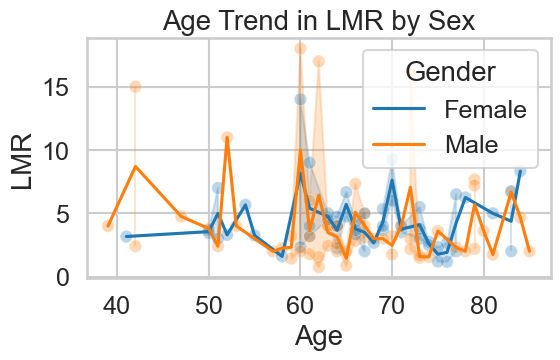

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

for var in ['Albumin', 'NLR', 'PLT', 'ANC', 'LMR']:
    plt.figure(figsize=(6, 4))
    sns.lineplot(x='Age', y=var, hue='Gender',
                 data=df, estimator='mean', ci=95)
    sns.scatterplot(x='Age', y=var, hue='Gender', data=df,
                    alpha=0.3, legend=False)
    plt.title(f"Age Trend in {var} by Sex")
    plt.tight_layout()
    plt.show()

<Figure size 800x600 with 0 Axes>

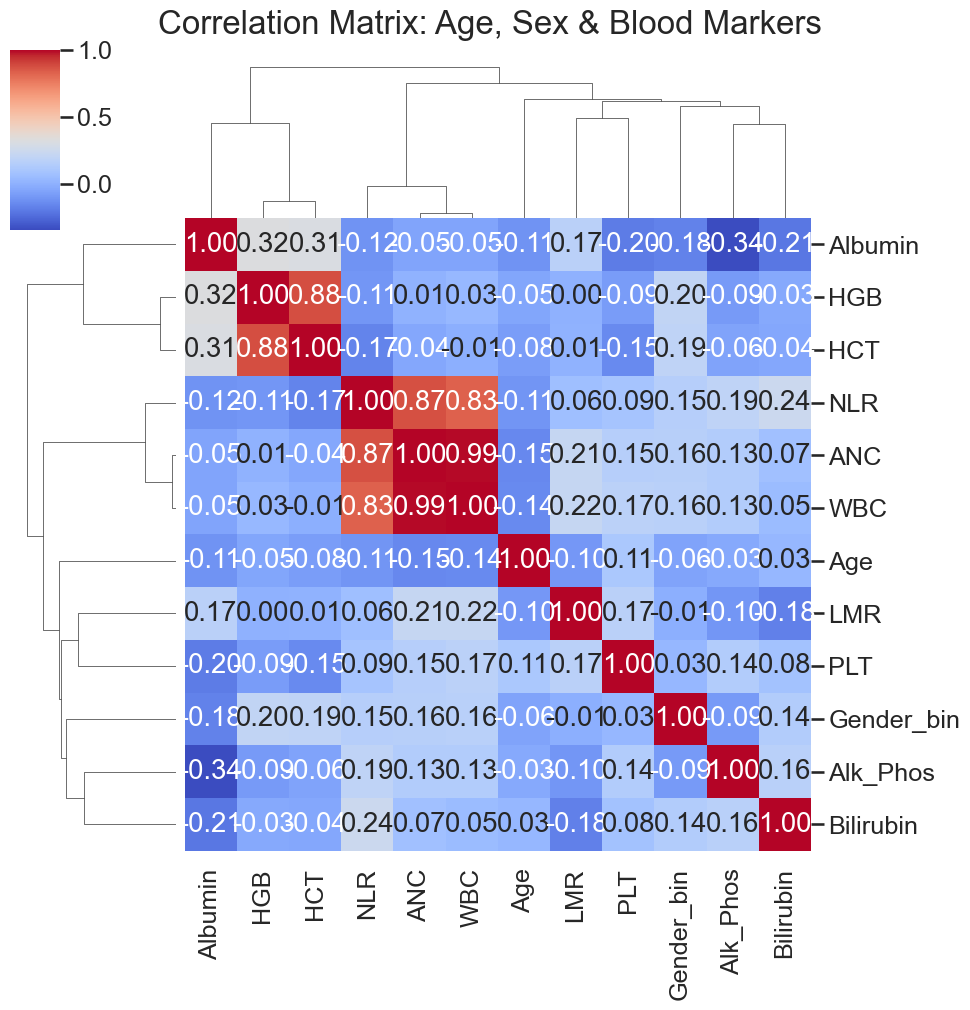

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = df[['Age', 'Gender_bin', 'Albumin', 'LMR', 'ANC', 'NLR', 'PLT',
           'WBC', 'HGB', 'HCT', 'Alk_Phos', 'Bilirubin']].corr()

plt.figure(figsize=(8, 6))
sns.clustermap(corr, annot=True, fmt=".2f", cmap='coolwarm',
               row_cluster=True, col_cluster=True)
plt.suptitle("Correlation Matrix: Age, Sex & Blood Markers", y=1.02)
plt.show()

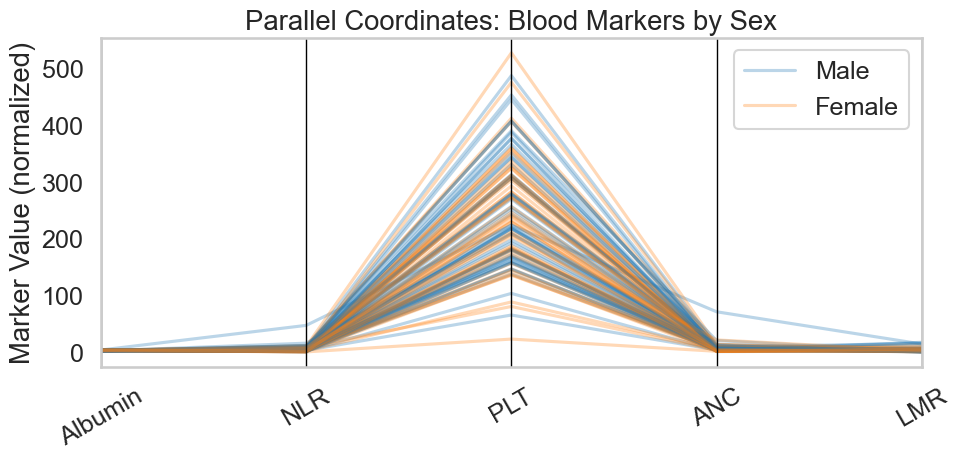

In [24]:
from pandas.plotting import parallel_coordinates

# Select a subset for clarity, and categorize age
df_pc = df[['Gender', 'Age_bin', 'Albumin',
            'NLR', 'PLT', 'ANC', 'LMR']].dropna()
df_pc['Age_bin'] = df_pc['Age_bin'].astype(str)

plt.figure(figsize=(10, 5))
parallel_coordinates(df_pc, class_column='Gender',
                     cols=['Albumin', 'NLR', 'PLT', 'ANC', 'LMR'],
                     color=['#1f77b4', '#ff7f0e'], alpha=0.3)
plt.title("Parallel Coordinates: Blood Markers by Sex")
plt.ylabel("Marker Value (normalized)")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

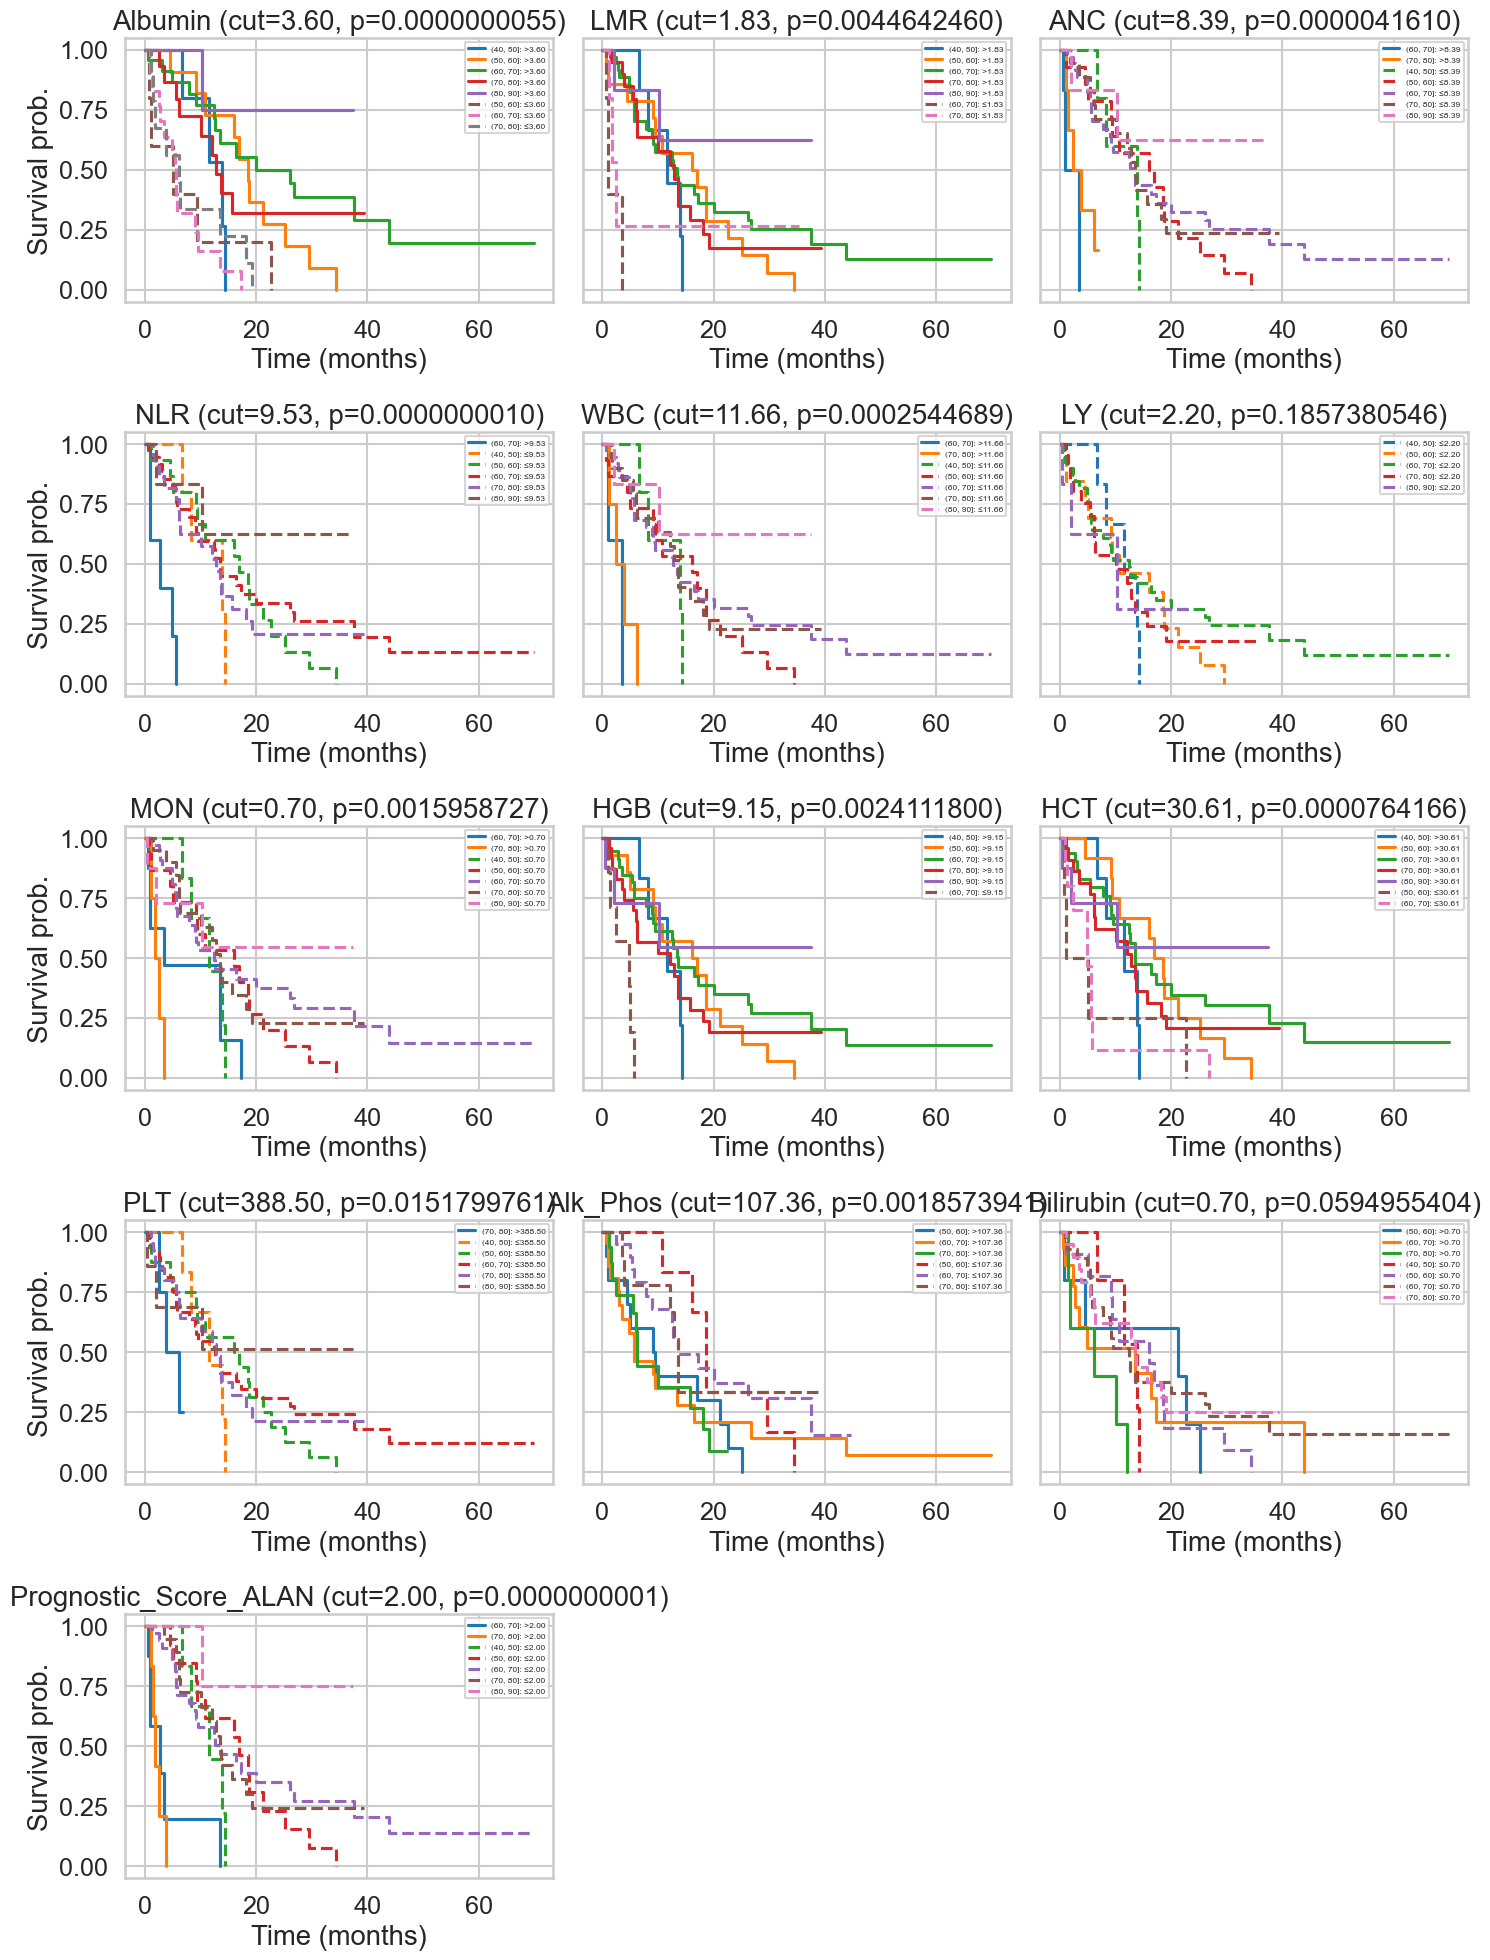

In [25]:
import math
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

# Define age bins (10‑year bins here; adjust as needed)
df['Age_bin'] = pd.cut(df['Age'], bins=np.arange(30, 100, 10))

kmf = KaplanMeierFitter()
vars_to_plot = vars_to_cut  # e.g. ['Albumin','LMR',...]

cols = 3
rows = math.ceil(len(vars_to_plot) / cols)
fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows), sharey=True)
axes = axes.flatten()

for i, var in enumerate(vars_to_plot):
    ax = axes[i]
    cut = cutpoints[var]
    for age_group in df['Age_bin'].cat.categories:
        mask = (df['Age_bin'] == age_group) & (df[var] > cut)
        if mask.sum() < 5:
            continue
        kmf.fit(df.loc[mask, 'time_diff_months'],
                df.loc[mask, 'Event_Status'],
                label=f"{age_group}: >{cut:.2f}")
        kmf.plot_survival_function(ax=ax, ci_show=False)
    # Also plot the “low” group for each age_bin
    for age_group in df['Age_bin'].cat.categories:
        mask = (df['Age_bin'] == age_group) & (df[var] <= cut)
        if mask.sum() < 5:
            continue
        kmf.fit(df.loc[mask, 'time_diff_months'],
                df.loc[mask, 'Event_Status'],
                label=f"{age_group}: ≤{cut:.2f}")
        kmf.plot_survival_function(ax=ax, ci_show=False, linestyle='--')
    # Overall log‑rank across high vs low within all ages
    low = df[df[var] <= cut]
    high = df[df[var] > cut]
    p = logrank_test(low['time_diff_months'], high['time_diff_months'],
                     event_observed_A=low['Event_Status'],
                     event_observed_B=high['Event_Status']).p_value
    ax.set_title(f"{var} (cut={cut:.2f}, p={p:.10f})")
    ax.set_xlabel("Time (months)")
    ax.set_ylabel("Survival prob.")
    ax.legend(fontsize=6)
# Hide unused
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

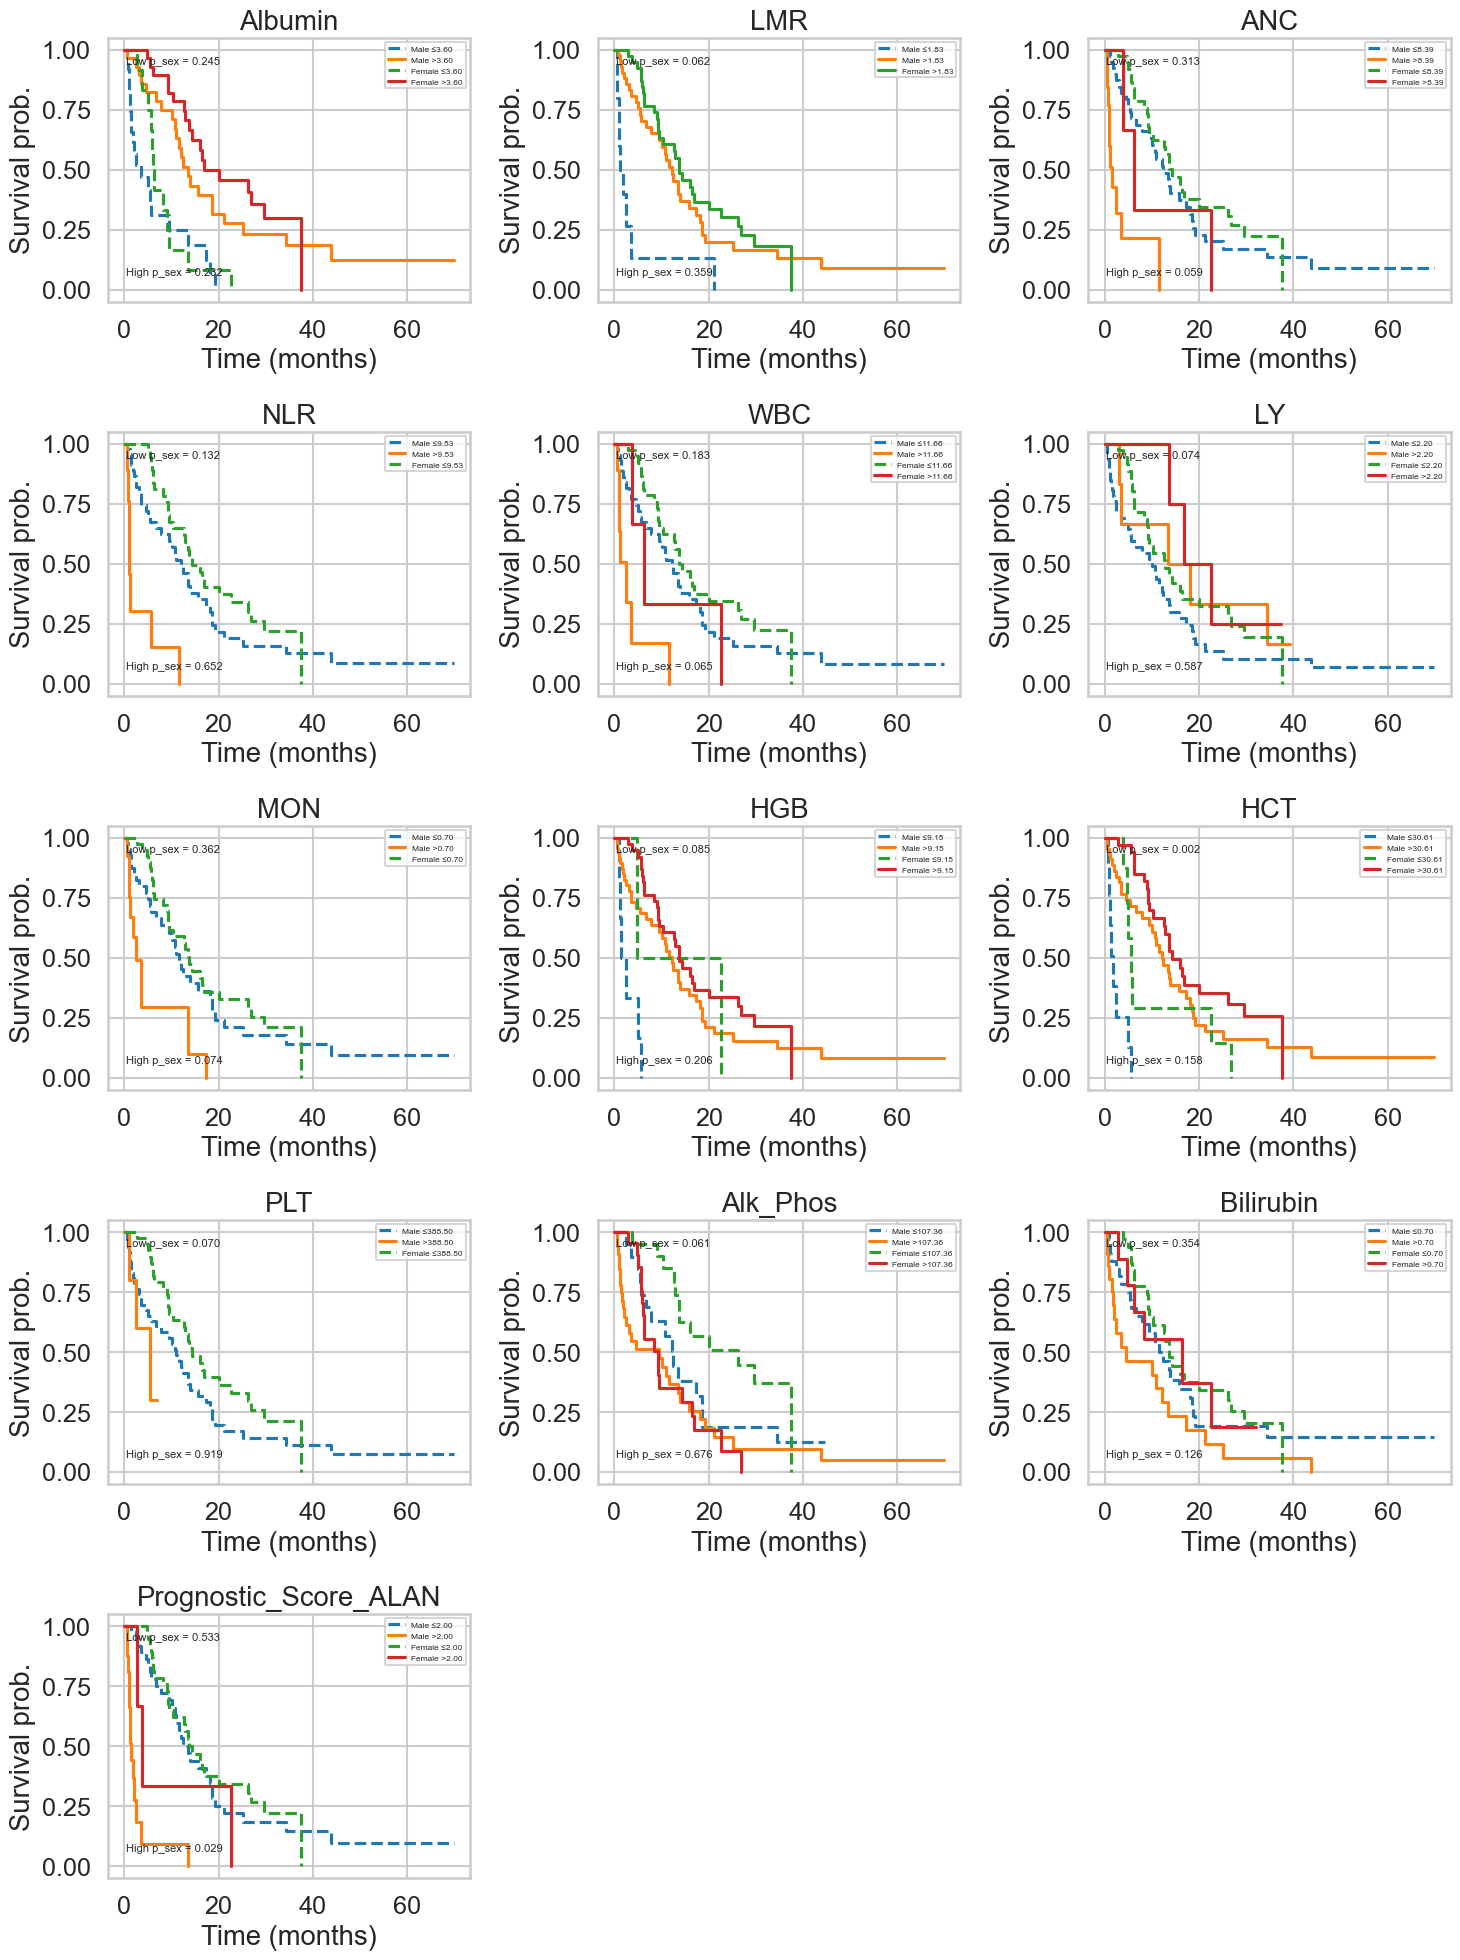

In [26]:
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

kmf = KaplanMeierFitter()
vars_to_plot = vars_to_cut

cols = 3
rows = math.ceil(len(vars_to_plot) / cols)
fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
axes = axes.flatten()

for i, var in enumerate(vars_to_plot):
    ax = axes[i]
    cut = cutpoints[var]
    for sex in ['Male', 'Female']:
        for flag, style in zip([0, 1], ['--', '-']):
            mask = (df['Gender'] == sex) & (
                df[var] > cut if flag == 1 else df[var] <= cut)
            if mask.sum() < 5:
                continue
            label = f"{sex} {'>' if flag else '≤'}{cut:.2f}"
            kmf.fit(df.loc[mask, 'time_diff_months'],
                    df.loc[mask, 'Event_Status'], label=label)
            kmf.plot_survival_function(ax=ax, ci_show=False, linestyle=style)
    # log‑rank by sex for high group
    for flag in [0, 1]:
        lo = df[(df[var] <= cut) & (df['Gender'] == 'Male')] if flag == 0 else df[(
            df[var] > cut) & (df['Gender'] == 'Male')]
        hi = df[(df[var] <= cut) & (df['Gender'] == 'Female')] if flag == 0 else df[(
            df[var] > cut) & (df['Gender'] == 'Female')]
        if len(lo) and len(hi):
            p = logrank_test(lo['time_diff_months'], hi['time_diff_months'],
                             event_observed_A=lo['Event_Status'], event_observed_B=hi['Event_Status']).p_value
            ax.text(0.05, 0.1 if flag else 0.9,
                    f"{'High' if flag else 'Low'} p_sex = {p:.3f}",
                    transform=ax.transAxes, fontsize=8)
    ax.set_title(var)
    ax.set_xlabel("Time (months)")
    ax.set_ylabel("Survival prob.")
    ax.legend(fontsize=6)
# Hide extras
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

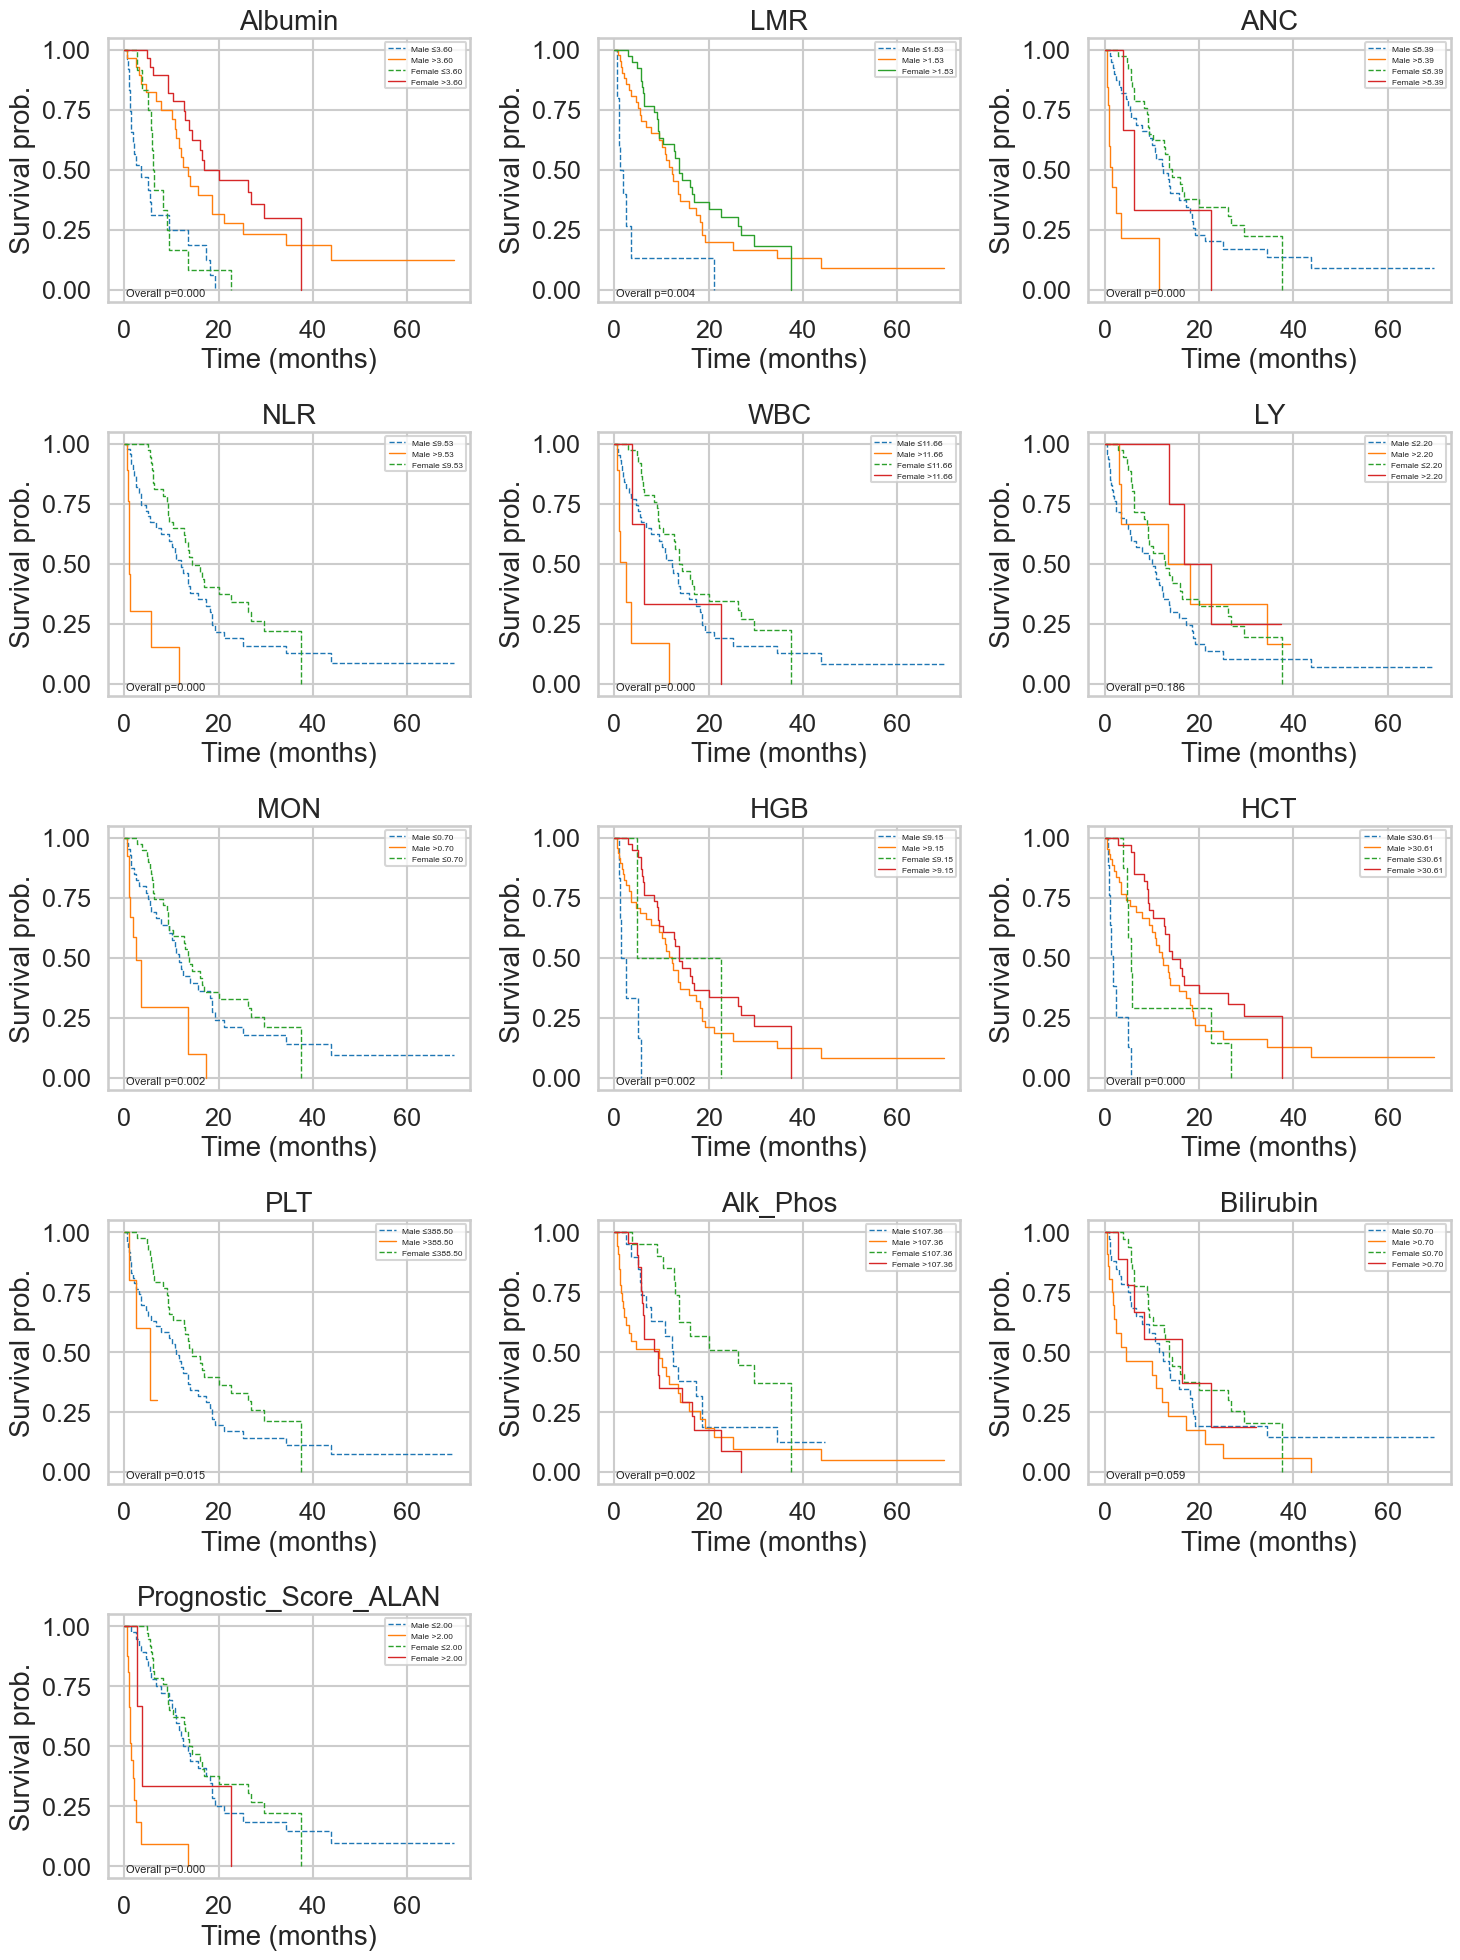

In [27]:
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

kmf = KaplanMeierFitter()
vars_to_plot = vars_to_cut

cols = 3
rows = math.ceil(len(vars_to_plot) / cols)
fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
axes = axes.flatten()

for i, var in enumerate(vars_to_plot):
    ax = axes[i]
    cut = cutpoints[var]
    # Four groups
    for sex, marker in [('Male', 0), ('Male', 1), ('Female', 0), ('Female', 1)]:
        mask = (df['Gender'] == sex) & (
            df[var] > cut if marker else df[var] <= cut)
        if mask.sum() < 5:
            continue
        label = f"{sex} {'>' if marker else '≤'}{cut:.2f}"
        kmf.fit(df.loc[mask, 'time_diff_months'],
                df.loc[mask, 'Event_Status'], label=label)
        kmf.plot_survival_function(ax=ax, ci_show=False,
                                   linestyle='-' if marker else '--',
                                   linewidth=1)
    # global log‑rank high vs low
    lo = df[df[var] <= cut]
    hi = df[df[var] > cut]
    p = logrank_test(lo['time_diff_months'], hi['time_diff_months'],
                     event_observed_A=lo['Event_Status'], event_observed_B=hi['Event_Status']).p_value
    ax.text(0.05, 0.02, f"Overall p={p:.3f}",
            transform=ax.transAxes, fontsize=8)
    ax.set_title(var)
    ax.set_xlabel("Time (months)")
    ax.set_ylabel("Survival prob.")
    ax.legend(fontsize=6)
# hide
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [28]:
from lifelines import CoxPHFitter

# Build a DataFrame with interactions
mv = df[['time_diff_months', 'Event_Status', 'Age', 'Gender_bin']].copy()
for var in vars_to_cut:
    mv[f"{var}_flag"] = df[f"{var}_flag"]
    mv[f"{var}_Age_int"] = mv['Age'] * mv[f"{var}_flag"]
    mv[f"{var}_Sex_int"] = mv['Gender_bin'] * mv[f"{var}_flag"]

cph_int = CoxPHFitter(penalizer=0.1)  # add penalizer if many terms
cph_int.fit(mv, 'time_diff_months', 'Event_Status')
cph_int.print_summary()

<lifelines.CoxPHFitter: fitted with 106 total observations, 34 right-censored observations>
             duration col = 'time_diff_months'
                event col = 'Event_Status'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 106
number of events observed = 72
   partial log-likelihood = -230.17
         time fit was run = 2025-04-18 06:33:46 UTC

---
                               coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                      
Age                            0.00      1.00      0.02           -0.04            0.04                0.96                1.04
Gender_bin                     0.33      1.39      0.51           -0.67            1.33                0.51                3.78
Albumin_flag                  -0.55      0.58      0.46           -1.46            0.37                0.23                1.44
Albumin_Age_int               -0.01      0.99      0.01           -0.02            0.00                0.98                1.00
Albumin_Sex_int                0.22      1.25      0.45           -0.65            1.09                0.52                2.99
LMR_flag                      -0.06      0.94      0.67           -1.37            1.25                0.25                3.49
LMR_Age_int                   -0.00      1.00      0.01           -0.02            0.02                0.98                1.02
LMR_Sex_int                   -0.12      0.89      0.45           -1.01            0.77                0.37                2.16
ANC_flag                      -0.02      0.98      0.65           -1.31            1.26                0.27                3.52
ANC_Age_int                    0.01      1.01      0.01           -0.01            0.03                0.99                1.03
ANC_Sex_int                    0.78      2.19      0.71           -0.61            2.18                0.54                8.83
NLR_flag                       0.42      1.52      0.72           -0.99            1.83                0.37                6.26
NLR_Age_int                    0.01      1.01      0.01           -0.01            0.03                0.99                1.03
NLR_Sex_int                    0.05      1.05      0.74           -1.41            1.51                0.25                4.51
WBC_flag                      -0.69      0.50      0.74           -2.14            0.76                0.12                2.15
WBC_Age_int                    0.00      1.00      0.01           -0.02            0.02                0.98                1.02
WBC_Sex_int                    0.09      1.09      0.81           -1.50            1.68                0.22                5.35
LY_flag                       -0.39      0.68      0.71           -1.78            1.00                0.17                2.72
LY_Age_int                    -0.00      1.00      0.01           -0.02            0.02                0.98                1.02
LY_Sex_int                     0.71      2.04      0.73           -0.71            2.14                0.49                8.46
MON_flag                      -0.74      0.48      0.70           -2.12            0.64                0.12                1.89
MON_Age_int                   -0.00      1.00      0.01           -0.03            0.02                0.97                1.02
MON_Sex_int                    0.50      1.65      0.72           -0.91            1.91                0.40                6.75
HGB_flag                      -0.23      0.79      0.72           -1.65            1.19                0.19                3.28
HGB_Age_int                   -0.01      0.99      0.01           -0.03            0.02                0.97                1.02
HGB_Sex_int                   -0.25      0.78      0.51           -1.24            0.75                0.2

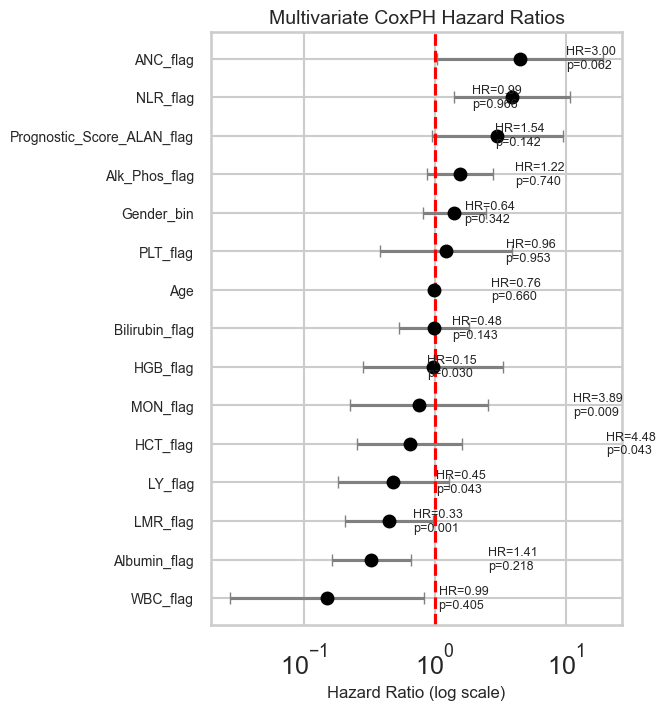

In [29]:
# 1. Forest Plot of Multivariate CoxPH Model

import matplotlib.pyplot as plt
import numpy as np

def plot_multivariate_forest(cph_model):
    """
    Plot a forest of multivariate CoxPH hazard ratios with 95% CIs,
    annotating each point with HR and p-value.
    """
    # Extract summary and compute HR & CIs
    summary = cph_model.summary.reset_index()
    summary['HR']      = summary['exp(coef)']
    summary['CI_low']  = summary['exp(coef) lower 95%']
    summary['CI_high'] = summary['exp(coef) upper 95%']
    summary['p']       = summary['p']
    summary.sort_values('HR', inplace=True)
    
    # Set up plot
    y = np.arange(len(summary))
    fig, ax = plt.subplots(figsize=(7, len(y)*0.5))
    
    # Error bars
    ax.errorbar(
        summary['HR'], y,
        xerr=[summary['HR']-summary['CI_low'], summary['CI_high']-summary['HR']],
        fmt='o', color='black', ecolor='gray', capsize=4
    )
    ax.axvline(1, color='red', linestyle='--')
    
    # Annotate HR and p-value to the right of each error bar
    for i, row in summary.iterrows():
        ax.text(row['CI_high'] * 1.05, y[i],
                f"HR={row['HR']:.2f}\np={row['p']:.3f}",
                va='center', ha='left', fontsize=9)
    
    # Labeling
    ax.set_yticks(y)
    ax.set_yticklabels(summary['covariate'], fontsize=10)
    ax.set_xscale('log')
    ax.set_xlabel('Hazard Ratio (log scale)', fontsize=12)
    ax.set_title('Multivariate CoxPH Hazard Ratios', fontsize=14)
    plt.tight_layout()
    plt.show()

# Usage:
plot_multivariate_forest(cph_mv)


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.91      1.00      0.95        29
           1       0.00      0.00      0.00         3

    accuracy                           0.91        32
   macro avg       0.45      0.50      0.48        32
weighted avg       0.82      0.91      0.86        32

Test ROC AUC: 0.6781609195402298


c:\Users\ajboo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ajboo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ajboo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

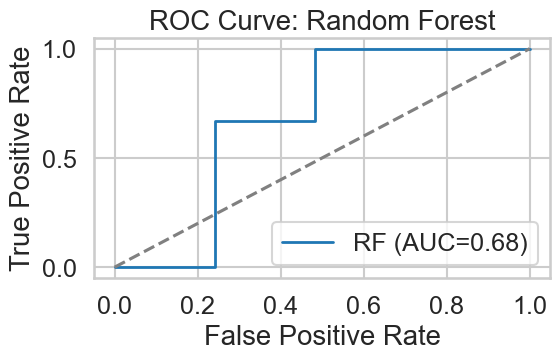

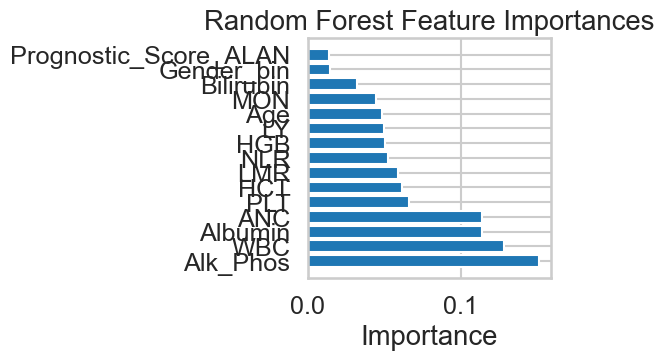

In [30]:
# 2. Machine Learning Pipeline for 24‑Month Survival Prediction

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report, roc_curve
import matplotlib.pyplot as plt
import shap

# Prepare features and target
# Use continuous variables + flags + Age + Sex_bin
# or add f"{v}_flag" for binary features
features = ['Age', 'Gender_bin'] + vars_to_cut
X = df[features]
y = df['surv_24']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Hyperparameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6, None],
    'min_samples_split': [2, 5]
}

# Cross‑validated grid search
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf = RandomForestClassifier(random_state=42)
grid = GridSearchCV(rf, param_grid, cv=cv, scoring='roc_auc', n_jobs=-1)
grid.fit(X_train, y_train)
best_rf = grid.best_estimator_

# Evaluate on test set
y_pred = best_rf.predict(X_test)
y_proba = best_rf.predict_proba(X_test)[:, 1]
print("=== Classification Report ===")
print(classification_report(y_test, y_pred))
print("Test ROC AUC:", roc_auc_score(y_test, y_proba))

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, lw=2, label=f"RF (AUC={roc_auc_score(y_test,y_proba):.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: Random Forest")
plt.legend()
plt.tight_layout()
plt.show()

# Feature importance
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(6, 4))
plt.barh(np.array(features)[indices], importances[indices])
plt.xlabel("Importance")
plt.title("Random Forest Feature Importances")
plt.tight_layout()
plt.show()

# 7. SHAP Summary for RandomForestClassifier – two options






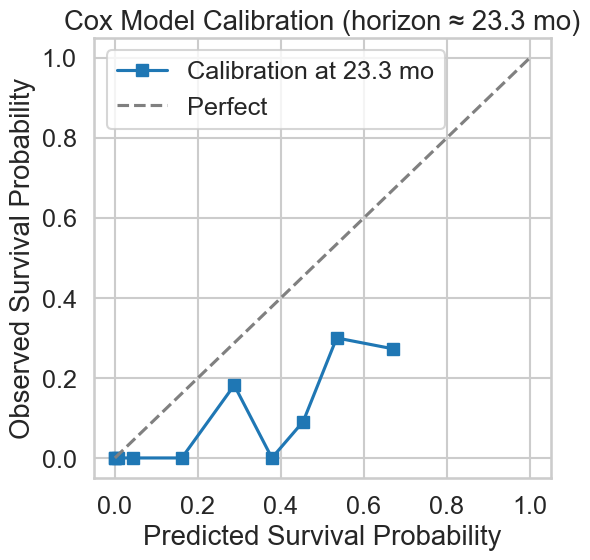

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve


def plot_cox_calibration(cph_model, df, time_horizon: float = 24.0) -> None:
    """
    Plot calibration curve comparing predicted survival at the nearest time point
    to `time_horizon` months against observed Kaplan–Meier estimates.
    """
    # Predict the full survival function for each subject
    surv_funcs = cph_model.predict_survival_function(
        df)  # DataFrame: index = time, cols = subjects

    # Find index in surv_funcs closest to time_horizon
    times = surv_funcs.index.values
    idx = np.abs(times - time_horizon).argmin()
    nearest_time = times[idx]

    # Extract predicted survival probs at that nearest time
    preds = surv_funcs.iloc[idx, :]

    # Observed: event-free at time_horizon
    obs = ((df['time_diff_months'] >= time_horizon)
           & (df['Event_Status'] == 0)).astype(int)

    # Compute calibration curve
    frac_pos, mean_pred = calibration_curve(
        obs, preds, n_bins=10, strategy='quantile')

    # Plot
    plt.figure(figsize=(6, 6))
    plt.plot(mean_pred, frac_pos, 's-',
             label=f'Calibration at {nearest_time:.1f} mo')
    plt.plot([0, 1], [0, 1], '--', color='gray', label='Perfect')
    plt.xlabel('Predicted Survival Probability')
    plt.ylabel('Observed Survival Probability')
    plt.title(f'Cox Model Calibration (horizon ≈ {nearest_time:.1f} mo)')
    plt.legend()
    plt.tight_layout()
    plt.show()


# ── Usage ──
# After fitting your Cox model as `cph_mv`:
plot_cox_calibration(cph_mv, df, time_horizon=24.0)

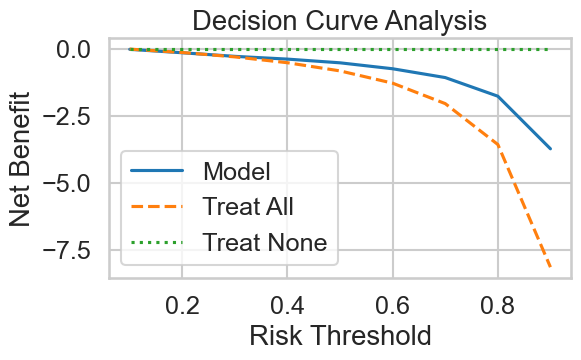

In [32]:
import numpy as np
import matplotlib.pyplot as plt


def plot_decision_curve(df, risk_scores: np.ndarray, true_label: str = 'surv_24') -> None:
    """
    Plot net benefit vs risk threshold.
    """
    n = len(df)
    obs = df[true_label].values
    thresholds = np.linspace(0.1, 0.9, 9)
    net_benefit = []
    for t in thresholds:
        treat = (risk_scores >= t).astype(int)
        tp = np.sum((treat == 1) & (obs == 1))
        fp = np.sum((treat == 1) & (obs == 0))
        nb = tp/n - fp/n * (t/(1-t))
        net_benefit.append(nb)
    plt.figure(figsize=(6, 4))
    plt.plot(thresholds, net_benefit, label='Model')
    # Treat all
    p_all = np.sum(obs == 1)/n
    nb_all = p_all - (1-p_all) * (thresholds/(1-thresholds))
    plt.plot(thresholds, nb_all, '--', label='Treat All')
    plt.plot(thresholds, np.zeros_like(thresholds), ':', label='Treat None')
    plt.xlabel('Risk Threshold')
    plt.ylabel('Net Benefit')
    plt.title('Decision Curve Analysis')
    plt.legend()
    plt.tight_layout()
    plt.show()


# ── Usage ──
# Obtain risk scores from your Cox model (partial hazards):
risk_scores = cph_mv.predict_partial_hazard(df).values.flatten()
plot_decision_curve(df, risk_scores, true_label='surv_24')

## Summary Table
Combine all metrics into a single table.

In [33]:
# Build summary DataFrame
rows = []
for var in vars_to_cut:
    row = {
        'Cutpoint': cutpoints[var], 'Cut_p': cut_pvals[var],
        'Coef_Age': lin_stats[var]['coef_age'], 'p_Age': lin_stats[var]['p_age'],
        'Coef_Sex': lin_stats[var]['coef_sex'], 'p_Sex': lin_stats[var]['p_sex'],
        'HR_Univ': cox_stats[var]['HR_univ'], 'p_Univ': cox_stats[var]['p_univ'],
        'HR_Adj': cox_stats[var]['HR_adj'], 'p_Adj': cox_stats[var]['p_adj'],
        'AUC_24mo': auc_stats[var], 'F1_24mo': f1_stats[var]
    }
    rows.append(row)
summary_df = pd.DataFrame(rows, index=vars_to_cut)
summary_df

Cutpoint         Cut_p  Coef_Age     p_Age  \
Albumin                  3.600000  5.456440e-09 -0.006589  0.199551   
LMR                      1.827143  4.464246e-03 -0.032486  0.307033   
ANC                      8.392857  4.161011e-06 -0.102293  0.143321   
NLR                      9.532143  9.858961e-10 -0.052843  0.305349   
WBC                     11.664286  2.544689e-04 -0.099217  0.162184   
LY                       2.200000  1.857381e-01  0.001646  0.796547   
MON                      0.700000  1.595873e-03  0.001709  0.487367   
HGB                      9.150000  2.411180e-03 -0.007304  0.700935   
HCT                     30.614286  7.641659e-05 -0.043453  0.491868   
PLT                    388.500000  1.517998e-02  1.079208  0.258995   
Alk_Phos               107.357143  1.857394e-03 -0.699773  0.730508   
Bilirubin                0.700000  5.949554e-02  0.007374  0.732320   
Prognostic_Score_ALAN    2.000000  9.481910e-11  0.014462  0.226406   

                        Coef_Sex     p_Sex   HR_Univ        p_Univ    HR_Adj  \
Albumin                -0.194183  0.061699  0.298094  3.476686e-07  0.312129   
LMR                    -0.107280  0.866675  0.951488  2.559799e-01  0.952519   
ANC                     2.158304  0.125460  1.016161  1.412693e-01  1.010178   
NLR                     1.573718  0.130801  1.032955  2.152937e-02  1.025545   
WBC                     2.271753  0.112583  1.015808  1.521773e-01  1.009731   
LY                      0.015597  0.903432  0.836702  3.470470e-01  0.802356   
MON                     0.131027  0.009252  3.304661  2.148958e-02  2.673387   
HGB                     0.784071  0.042661  0.911593  1.730019e-01  0.862857   
HCT                     2.451306  0.056117  0.962595  5.740026e-02  0.945311   
PLT                     6.577351  0.731976  1.001859  1.793007e-01  1.001880   
Alk_Phos              -37.829312  0.356118  1.002458  3.435934e-04  1.002551   
Bilirubin               0.619153  0.155860  1.188260  4.109788e-03  1.171463   
Prognostic_Score_ALAN   0.547977  0.024109  1.751571  8.438684e-07  1.720775   

                              p_Adj  AUC_24mo   F1_24mo  
Albumin                4.871332e-07  0.721649  0.250000  
LMR                    2.412099e-01  0.506300  0.156863  
ANC                    3.872358e-01  0.396907  0.000000  
NLR                    9.632519e-02  0.432990  0.000000  
WBC                    4.103478e-01  0.427835  0.000000  
LY                     2.628354e-01  0.554410  0.181818  
MON                    6.439248e-02  0.417526  0.000000  
HGB                    3.277065e-02  0.556701  0.173077  
HCT                    6.454414e-03  0.603093  0.189474  
PLT                    1.717275e-01  0.443299  0.000000  
Alk_Phos               3.008741e-04  0.246277  0.028571  
Bilirubin              1.004558e-02  0.380298  0.045455  
Prognostic_Score_ALAN  1.991579e-06  0.386598  0.000000

In [34]:
# If your environment already has a TeX engine installed:
!jupyter nbconvert --to pdf --TemplateExporter.exclude_input=True pbt_analysis.ipynb


[NbConvertApp] Converting notebook pbt_analysis.ipynb to pdf
[NbConvertApp] ERROR | Error while converting 'pbt_analysis.ipynb'
Traceback (most recent call last):
  File "C:\Users\ajboo\anaconda3\Lib\site-packages\nbconvert\nbconvertapp.py", line 479, in export_single_notebook
    output, resources = self.exporter.from_filename(
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ajboo\anaconda3\Lib\site-packages\nbconvert\exporters\templateexporter.py", line 389, in from_filename
    return super().from_filename(filename, resources, **kw)  # type:ignore[return-value]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ajboo\anaconda3\Lib\site-packages\nbconvert\exporters\exporter.py", line 203, in from_filename
    return self.from_file(f, resources=resources, **kw)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ajboo\anaconda3\Lib\site-packages\nbconvert\exporters\templateexporter.py", line 395, in from_file
    ret